# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import accuracy_fn, cohen_kappa_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

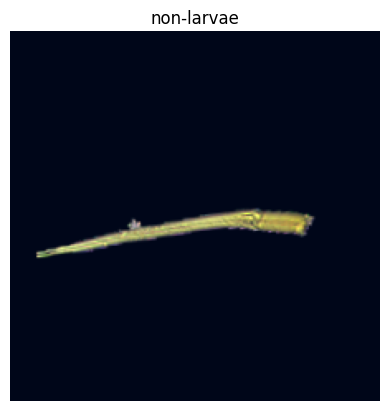

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[16,32,64,128],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [10]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=3e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7101 | Val Loss: 0.6525 | Train cohen_kappa_fn: 0.1383 | Val cohen_kappa_fn: 0.1756 | Train accuracy_fn: 0.5006 | Val accuracy_fn: 0.5486
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6152 | Val Loss: 0.5861 | Train cohen_kappa_fn: 0.1439 | Val cohen_kappa_fn: 0.1625 | Train accuracy_fn: 0.4631 | Val accuracy_fn: 0.4859
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5709 | Val Loss: 0.5260 | Train cohen_kappa_fn: 0.4453 | Val cohen_kappa_fn: 0.3677 | Train accuracy_fn: 0.8210 | Val accuracy_fn: 0.8495
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5051 | Val Loss: 0.4199 | Train cohen_kappa_fn: 0.4256 | Val cohen_kappa_fn: 0.6246 | Train accuracy_fn: 0.8010 | Val accuracy_fn: 0.8966
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4355 | Val Loss: 0.4495 | Train cohen_kappa_fn: 0.2333 | Val cohen_kappa_fn: 0.2149 | Train accuracy_fn: 0.5720 | Val accuracy_fn: 0.5580
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3469 | Val Loss: 0.2328 | Train cohen_kappa_fn: 0.7675 | Val cohen_kappa_fn: 0.7334 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.9248
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2741 | Val Loss: 0.8005 | Train cohen_kappa_fn: 0.1009 | Val cohen_kappa_fn: 0.0680 | Train accuracy_fn: 0.3780 | Val accuracy_fn: 0.3166
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.2580 | Val Loss: 0.1619 | Train cohen_kappa_fn: 0.7670 | Val cohen_kappa_fn: 0.7839 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.9404
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2780 | Val Loss: 0.1644 | Train cohen_kappa_fn: 0.7338 | Val cohen_kappa_fn: 0.8001 | Train accuracy_fn: 0.9136 | Val accuracy_fn: 0.9436
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1892 | Val Loss: 0.2007 | Train cohen_kappa_fn: 0.6432 | Val cohen_kappa_fn: 0.6124 | Train accuracy_fn: 0.8748 | Val accuracy_fn: 0.8683
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2155 | Val Loss: 0.1325 | Train cohen_kappa_fn: 0.8535 | Val cohen_kappa_fn: 0.8472 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9592
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1608 | Val Loss: 0.5718 | Train cohen_kappa_fn: 0.3293 | Val cohen_kappa_fn: 0.2869 | Train accuracy_fn: 0.6683 | Val accuracy_fn: 0.6395
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1704 | Val Loss: 0.1646 | Train cohen_kappa_fn: 0.7809 | Val cohen_kappa_fn: 0.6997 | Train accuracy_fn: 0.9312 | Val accuracy_fn: 0.9060
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1327 | Val Loss: 0.1391 | Train cohen_kappa_fn: 0.8405 | Val cohen_kappa_fn: 0.8497 | Train accuracy_fn: 0.9537 | Val accuracy_fn: 0.9592
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1345 | Val Loss: 0.1259 | Train cohen_kappa_fn: 0.8760 | Val cohen_kappa_fn: 0.8497 | Train accuracy_fn: 0.9650 | Val accuracy_fn: 0.9592
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1295 | Val Loss: 0.2515 | Train cohen_kappa_fn: 0.5699 | Val cohen_kappa_fn: 0.5992 | Train accuracy_fn: 0.8385 | Val accuracy_fn: 0.8621
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1546 | Val Loss: 0.2160 | Train cohen_kappa_fn: 0.6084 | Val cohen_kappa_fn: 0.5675 | Train accuracy_fn: 0.8573 | Val accuracy_fn: 0.8464
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1274 | Val Loss: 0.1789 | Train cohen_kappa_fn: 0.9002 | Val cohen_kappa_fn: 0.8177 | Train accuracy_fn: 0.9725 | Val accuracy_fn: 0.9530
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1147 | Val Loss: 0.2355 | Train cohen_kappa_fn: 0.8682 | Val cohen_kappa_fn: 0.8334 | Train accuracy_fn: 0.9662 | Val accuracy_fn: 0.9592
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1216 | Val Loss: 0.1847 | Train cohen_kappa_fn: 0.7383 | Val cohen_kappa_fn: 0.6919 | Train accuracy_fn: 0.9149 | Val accuracy_fn: 0.9028
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


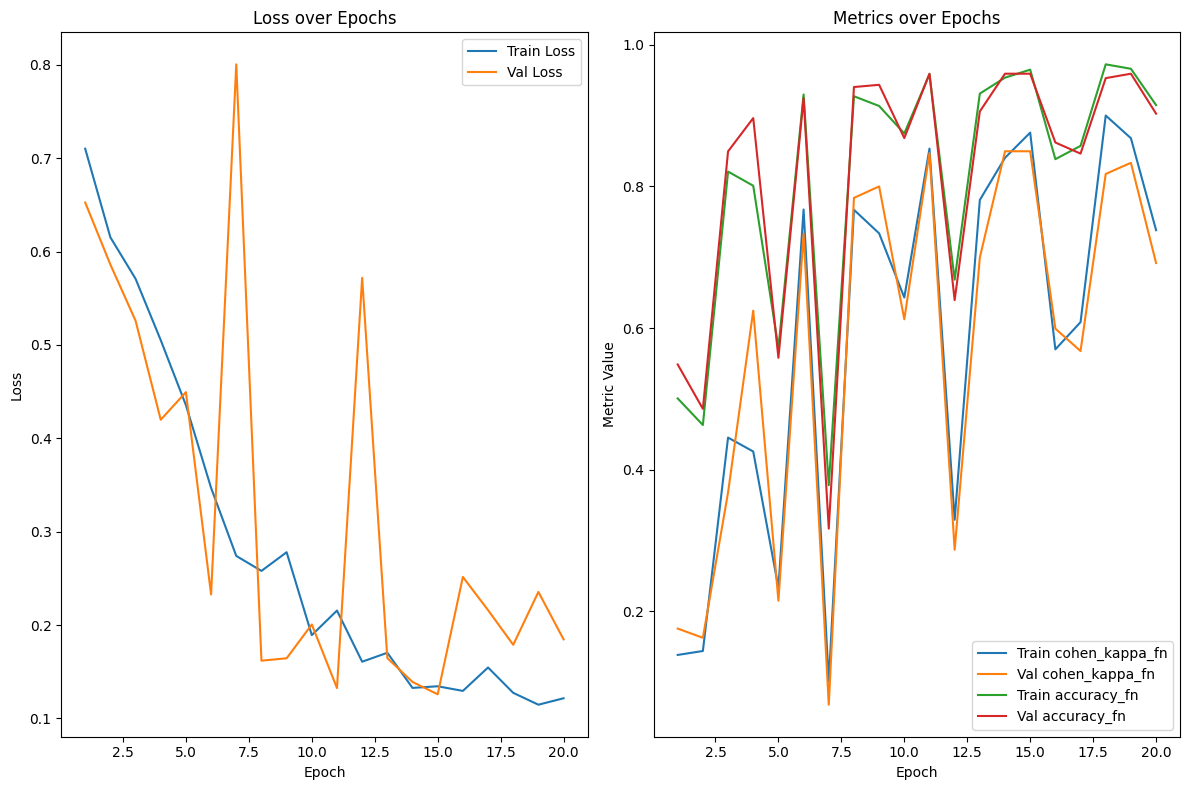

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2015 | Test cohen_kappa_fn: 0.8012 | Test accuracy_fn: 0.9458


### 3.3. CNN1

In [14]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [15]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=3e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [16]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6647 | Val Loss: 0.6248 | Train cohen_kappa_fn: 0.0919 | Val cohen_kappa_fn: 0.1272 | Train accuracy_fn: 0.3617 | Val accuracy_fn: 0.4295
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5953 | Val Loss: 0.5452 | Train cohen_kappa_fn: 0.2771 | Val cohen_kappa_fn: 0.4174 | Train accuracy_fn: 0.7409 | Val accuracy_fn: 0.8652
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5359 | Val Loss: 0.4992 | Train cohen_kappa_fn: 0.2024 | Val cohen_kappa_fn: 0.2410 | Train accuracy_fn: 0.5432 | Val accuracy_fn: 0.6113
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4832 | Val Loss: 0.4448 | Train cohen_kappa_fn: 0.3002 | Val cohen_kappa_fn: 0.3390 | Train accuracy_fn: 0.6546 | Val accuracy_fn: 0.7053
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4399 | Val Loss: 0.3780 | Train cohen_kappa_fn: 0.3839 | Val cohen_kappa_fn: 0.5642 | Train accuracy_fn: 0.7347 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4095 | Val Loss: 0.3612 | Train cohen_kappa_fn: 0.6720 | Val cohen_kappa_fn: 0.6804 | Train accuracy_fn: 0.8986 | Val accuracy_fn: 0.9091
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3456 | Val Loss: 0.2747 | Train cohen_kappa_fn: 0.7492 | Val cohen_kappa_fn: 0.7297 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3063 | Val Loss: 0.2524 | Train cohen_kappa_fn: 0.5794 | Val cohen_kappa_fn: 0.6735 | Train accuracy_fn: 0.8486 | Val accuracy_fn: 0.8934
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2592 | Val Loss: 0.3058 | Train cohen_kappa_fn: 0.4254 | Val cohen_kappa_fn: 0.4892 | Train accuracy_fn: 0.7559 | Val accuracy_fn: 0.7994
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2390 | Val Loss: 0.2576 | Train cohen_kappa_fn: 0.7335 | Val cohen_kappa_fn: 0.5728 | Train accuracy_fn: 0.9174 | Val accuracy_fn: 0.8464
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2047 | Val Loss: 0.2474 | Train cohen_kappa_fn: 0.5672 | Val cohen_kappa_fn: 0.5491 | Train accuracy_fn: 0.8360 | Val accuracy_fn: 0.8339
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1972 | Val Loss: 0.1963 | Train cohen_kappa_fn: 0.8030 | Val cohen_kappa_fn: 0.8867 | Train accuracy_fn: 0.9512 | Val accuracy_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2441 | Val Loss: 0.2875 | Train cohen_kappa_fn: 0.5766 | Val cohen_kappa_fn: 0.4943 | Train accuracy_fn: 0.8411 | Val accuracy_fn: 0.8025
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2200 | Val Loss: 0.1703 | Train cohen_kappa_fn: 0.7726 | Val cohen_kappa_fn: 0.6841 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.8997
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2100 | Val Loss: 0.1585 | Train cohen_kappa_fn: 0.7841 | Val cohen_kappa_fn: 0.7282 | Train accuracy_fn: 0.9349 | Val accuracy_fn: 0.9185
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1694 | Val Loss: 0.1726 | Train cohen_kappa_fn: 0.7795 | Val cohen_kappa_fn: 0.7034 | Train accuracy_fn: 0.9324 | Val accuracy_fn: 0.9091
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1717 | Val Loss: 0.2492 | Train cohen_kappa_fn: 0.5929 | Val cohen_kappa_fn: 0.5737 | Train accuracy_fn: 0.8486 | Val accuracy_fn: 0.8495
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1509 | Val Loss: 0.1727 | Train cohen_kappa_fn: 0.7995 | Val cohen_kappa_fn: 0.7504 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9279
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1759 | Val Loss: 0.1679 | Train cohen_kappa_fn: 0.8927 | Val cohen_kappa_fn: 0.8906 | Train accuracy_fn: 0.9712 | Val accuracy_fn: 0.9718
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1541 | Val Loss: 0.1619 | Train cohen_kappa_fn: 0.8640 | Val cohen_kappa_fn: 0.7969 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9436
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


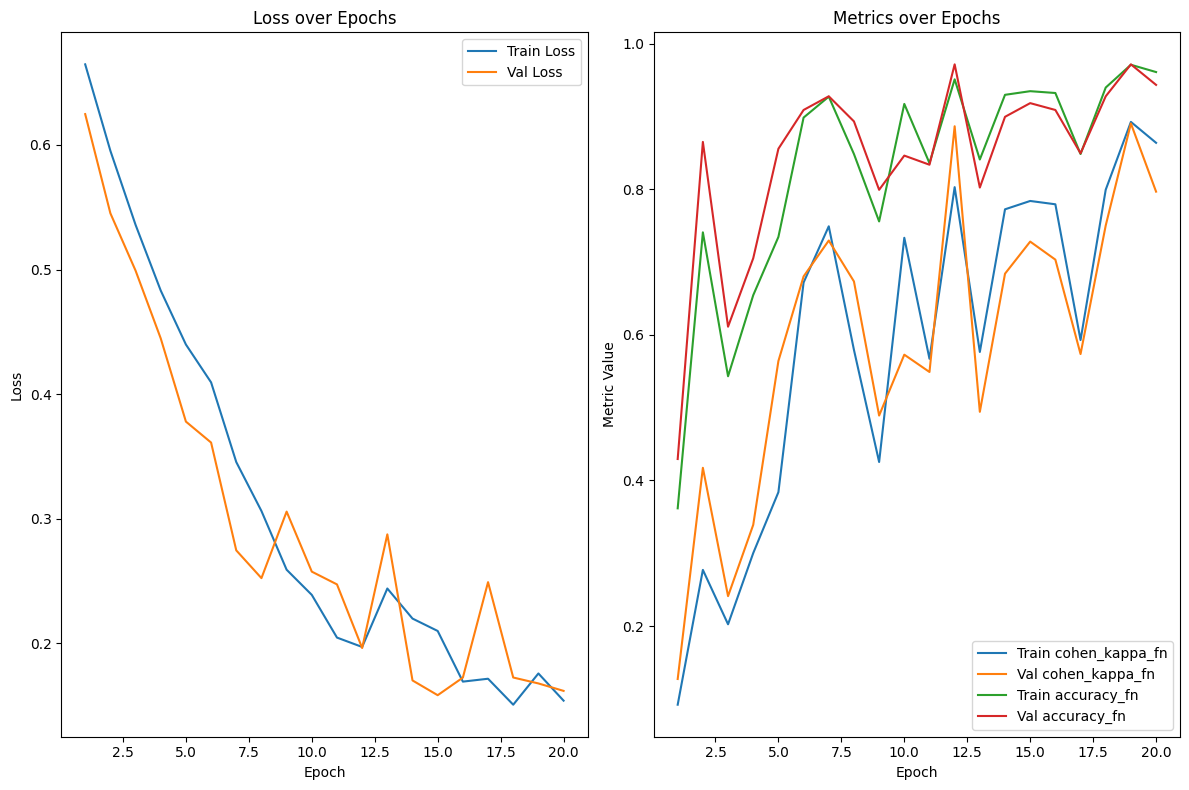

In [17]:
trainer_cnn_1.plot_epochs()

In [18]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2105 | Test cohen_kappa_fn: 0.7568 | Test accuracy_fn: 0.9312


#### Visualization

In [19]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

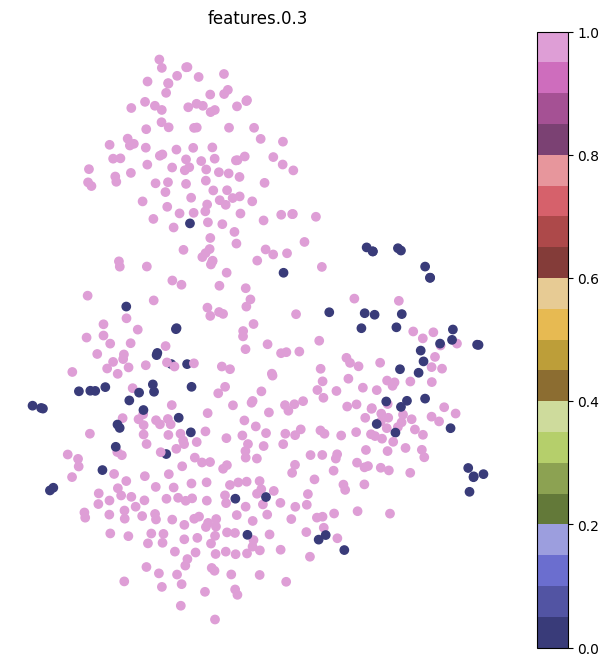

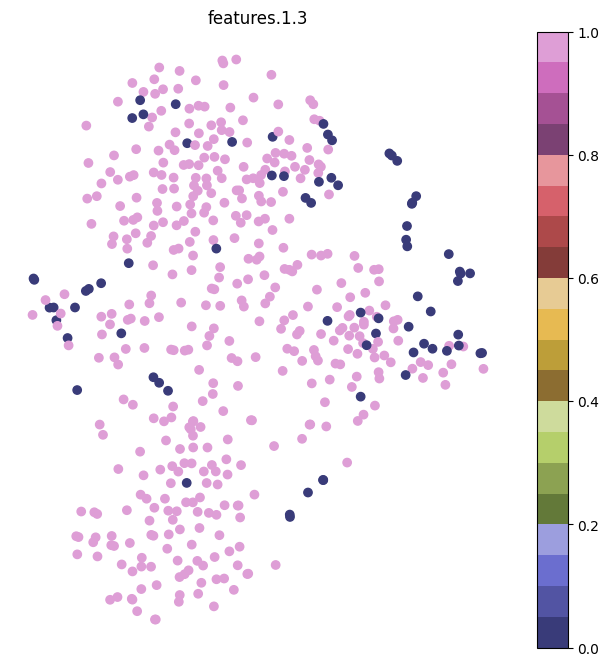

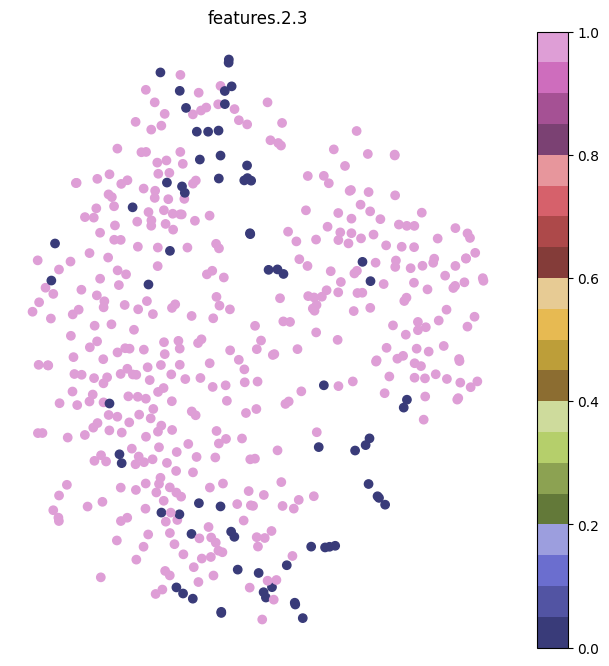

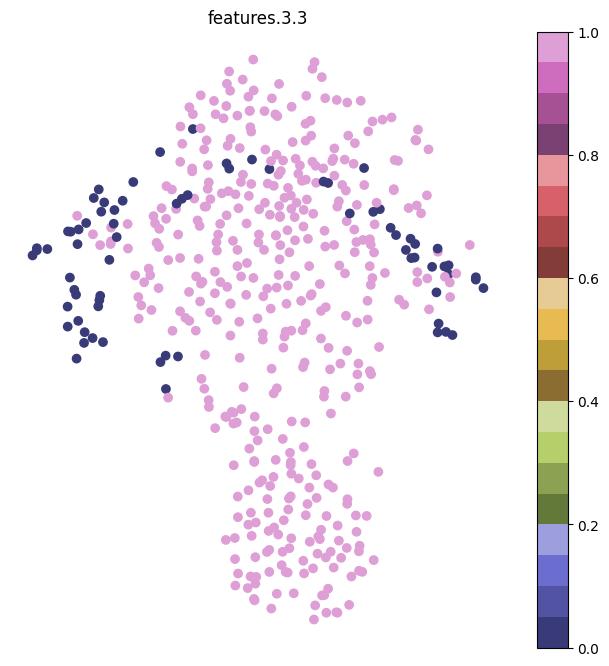

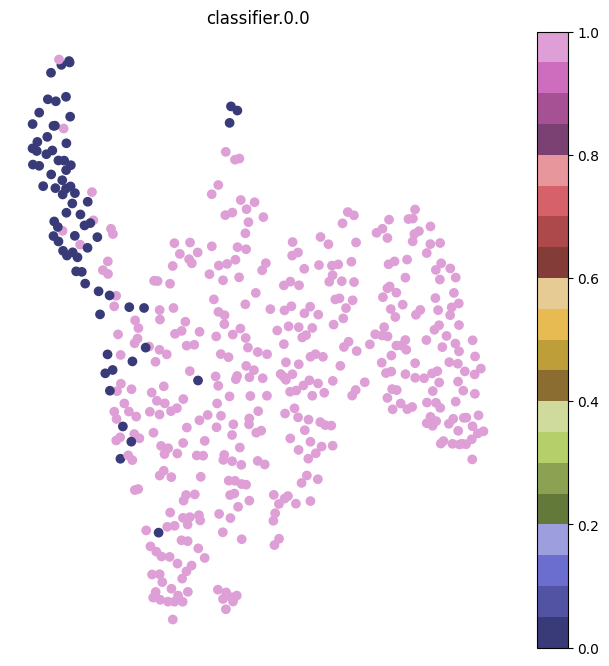

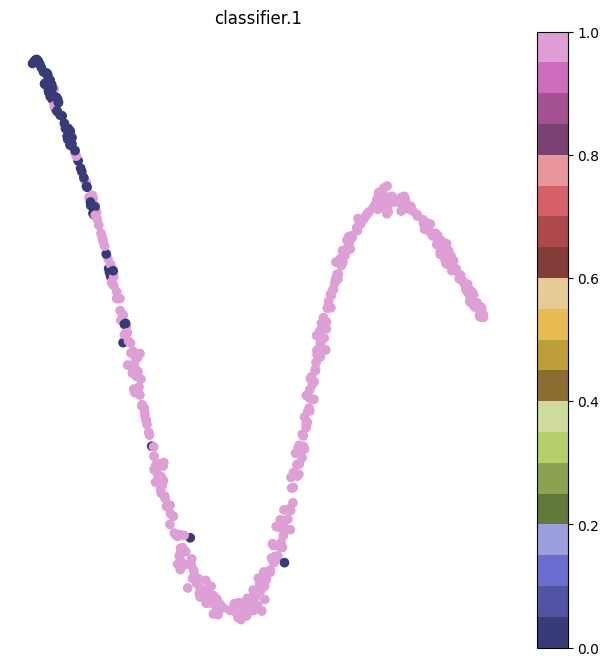

In [20]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


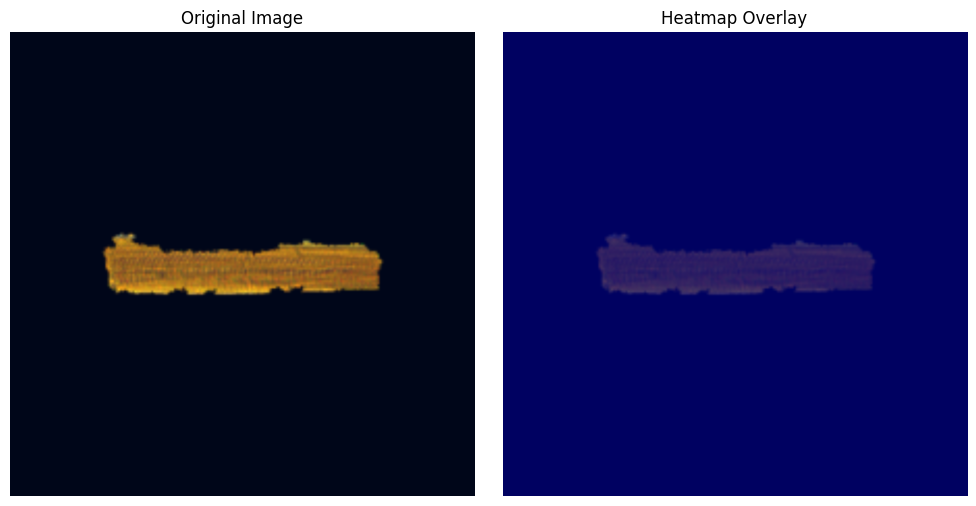

  Generating heatmap for Larvae...
  Predicted label is Larvae!


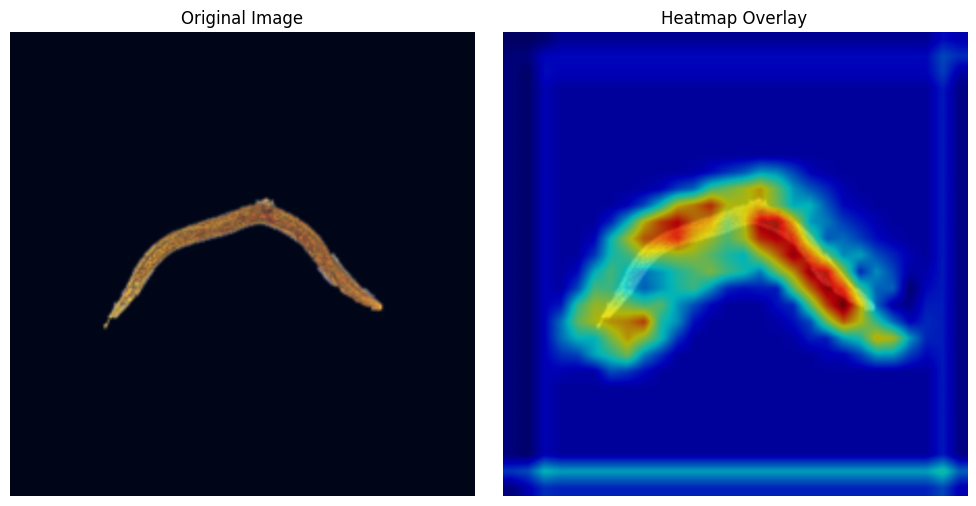

In [21]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [22]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [23]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=3e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [24]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6855 | Val Loss: 0.6473 | Train cohen_kappa_fn: 0.0835 | Val cohen_kappa_fn: -0.0513 | Train accuracy_fn: 0.6934 | Val accuracy_fn: 0.7335
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6138 | Val Loss: 0.5983 | Train cohen_kappa_fn: 0.1912 | Val cohen_kappa_fn: 0.2362 | Train accuracy_fn: 0.6421 | Val accuracy_fn: 0.7524
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5742 | Val Loss: 0.5216 | Train cohen_kappa_fn: 0.2375 | Val cohen_kappa_fn: 0.3012 | Train accuracy_fn: 0.5957 | Val accuracy_fn: 0.7147
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4929 | Val Loss: 0.4386 | Train cohen_kappa_fn: 0.2647 | Val cohen_kappa_fn: 0.3466 | Train accuracy_fn: 0.6220 | Val accuracy_fn: 0.7116
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4572 | Val Loss: 0.3800 | Train cohen_kappa_fn: 0.3034 | Val cohen_kappa_fn: 0.4774 | Train accuracy_fn: 0.6846 | Val accuracy_fn: 0.8213
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4291 | Val Loss: 0.3485 | Train cohen_kappa_fn: 0.4026 | Val cohen_kappa_fn: 0.5143 | Train accuracy_fn: 0.7584 | Val accuracy_fn: 0.8307
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4621 | Val Loss: 0.6727 | Train cohen_kappa_fn: 0.0796 | Val cohen_kappa_fn: 0.0430 | Train accuracy_fn: 0.3429 | Val accuracy_fn: 0.2602
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.4083 | Val Loss: 0.3154 | Train cohen_kappa_fn: 0.4751 | Val cohen_kappa_fn: 0.5148 | Train accuracy_fn: 0.7985 | Val accuracy_fn: 0.8245
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3492 | Val Loss: 0.3530 | Train cohen_kappa_fn: 0.3444 | Val cohen_kappa_fn: 0.3812 | Train accuracy_fn: 0.6859 | Val accuracy_fn: 0.7241
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.3138 | Val Loss: 0.2285 | Train cohen_kappa_fn: 0.6608 | Val cohen_kappa_fn: 0.7287 | Train accuracy_fn: 0.8949 | Val accuracy_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2690 | Val Loss: 0.2094 | Train cohen_kappa_fn: 0.7319 | Val cohen_kappa_fn: 0.7611 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.9342
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3054 | Val Loss: 0.2662 | Train cohen_kappa_fn: 0.7282 | Val cohen_kappa_fn: 0.7928 | Train accuracy_fn: 0.9324 | Val accuracy_fn: 0.9530
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2430 | Val Loss: 0.1903 | Train cohen_kappa_fn: 0.7557 | Val cohen_kappa_fn: 0.7936 | Train accuracy_fn: 0.9287 | Val accuracy_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2267 | Val Loss: 0.2214 | Train cohen_kappa_fn: 0.7185 | Val cohen_kappa_fn: 0.6351 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8809
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2377 | Val Loss: 0.1871 | Train cohen_kappa_fn: 0.8232 | Val cohen_kappa_fn: 0.8104 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9498
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2303 | Val Loss: 0.2288 | Train cohen_kappa_fn: 0.7449 | Val cohen_kappa_fn: 0.6006 | Train accuracy_fn: 0.9212 | Val accuracy_fn: 0.8652
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2136 | Val Loss: 0.2241 | Train cohen_kappa_fn: 0.7295 | Val cohen_kappa_fn: 0.5874 | Train accuracy_fn: 0.9136 | Val accuracy_fn: 0.8589
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1951 | Val Loss: 0.1774 | Train cohen_kappa_fn: 0.7887 | Val cohen_kappa_fn: 0.7778 | Train accuracy_fn: 0.9412 | Val accuracy_fn: 0.9373
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1823 | Val Loss: 0.3236 | Train cohen_kappa_fn: 0.4835 | Val cohen_kappa_fn: 0.4257 | Train accuracy_fn: 0.7872 | Val accuracy_fn: 0.7618
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1869 | Val Loss: 0.1677 | Train cohen_kappa_fn: 0.8386 | Val cohen_kappa_fn: 0.8165 | Train accuracy_fn: 0.9537 | Val accuracy_fn: 0.9498
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.1948 | Val Loss: 0.2066 | Train cohen_kappa_fn: 0.7454 | Val cohen_kappa_fn: 0.6875 | Train accuracy_fn: 0.9224 | Val accuracy_fn: 0.9028
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1750 | Val Loss: 0.2274 | Train cohen_kappa_fn: 0.7106 | Val cohen_kappa_fn: 0.6423 | Train accuracy_fn: 0.9061 | Val accuracy_fn: 0.8840
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1758 | Val Loss: 0.1900 | Train cohen_kappa_fn: 0.7679 | Val cohen_kappa_fn: 0.6875 | Train accuracy_fn: 0.9287 | Val accuracy_fn: 0.9028
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1615 | Val Loss: 0.1962 | Train cohen_kappa_fn: 0.8605 | Val cohen_kappa_fn: 0.8253 | Train accuracy_fn: 0.9625 | Val accuracy_fn: 0.9561
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1717 | Val Loss: 0.1701 | Train cohen_kappa_fn: 0.7950 | Val cohen_kappa_fn: 0.8097 | Train accuracy_fn: 0.9412 | Val accuracy_fn: 0.9467
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


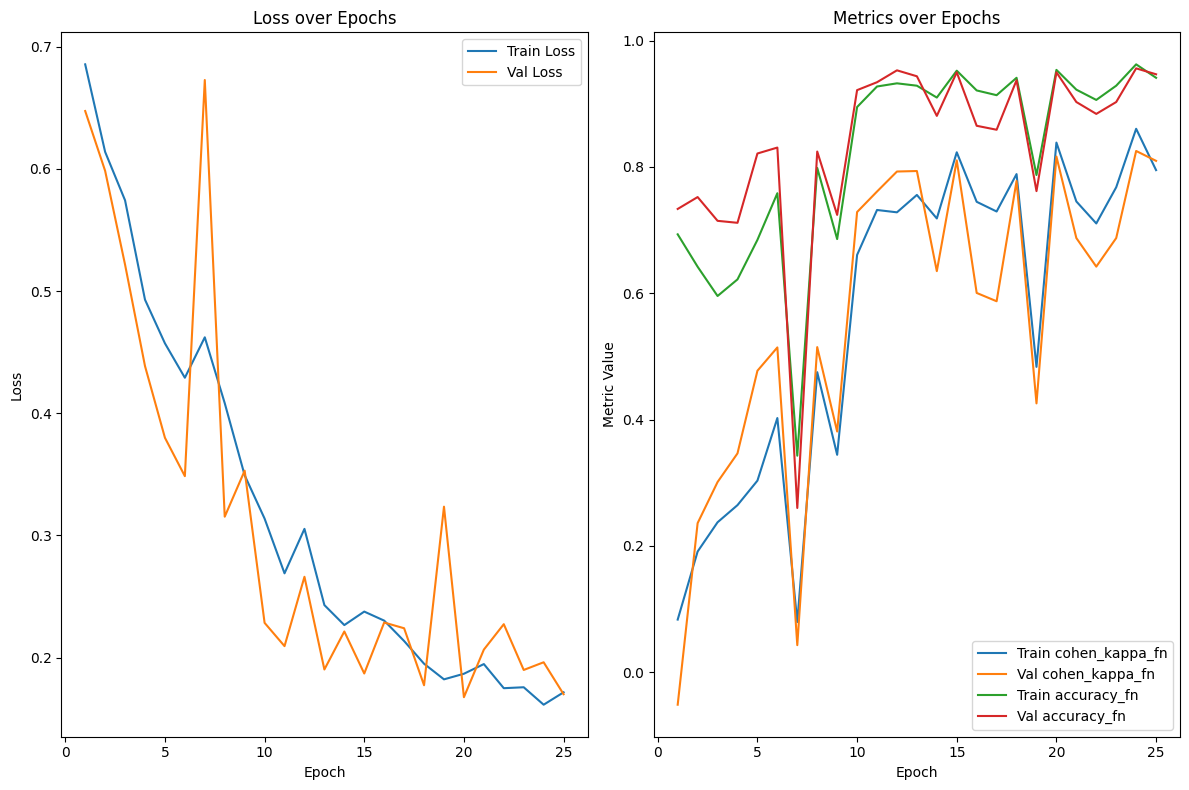

In [25]:
trainer_cnn_2.plot_epochs()

In [26]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2931 | Test cohen_kappa_fn: 0.7697 | Test accuracy_fn: 0.9396


#### Visualization

In [27]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

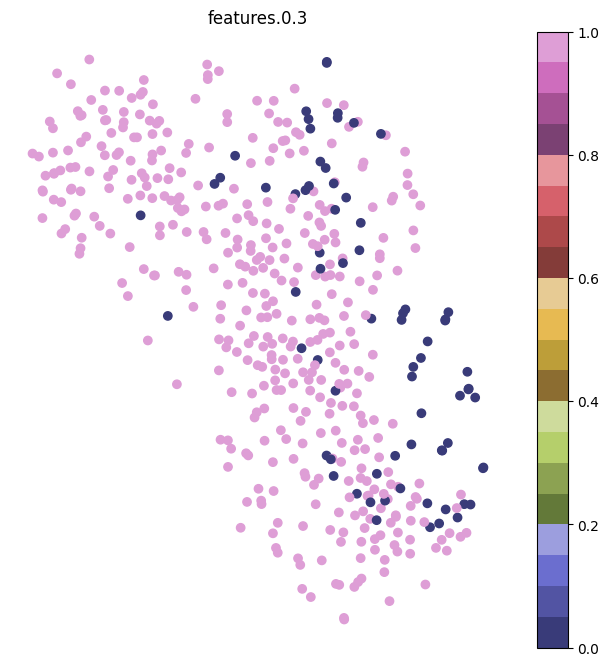

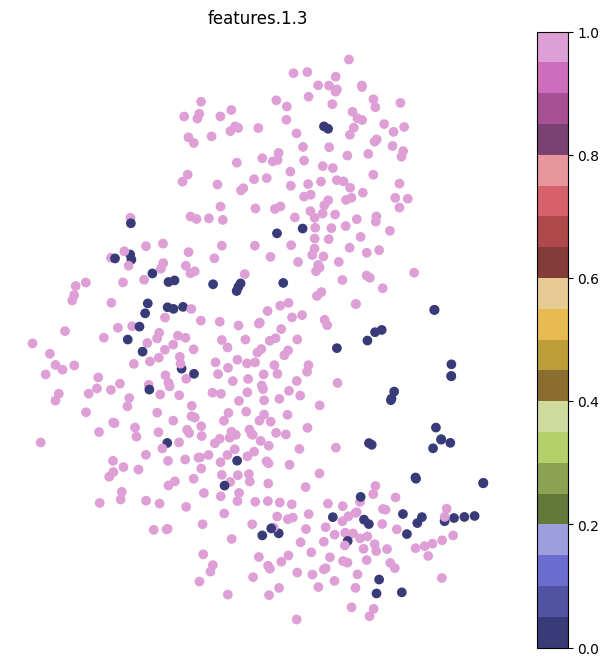

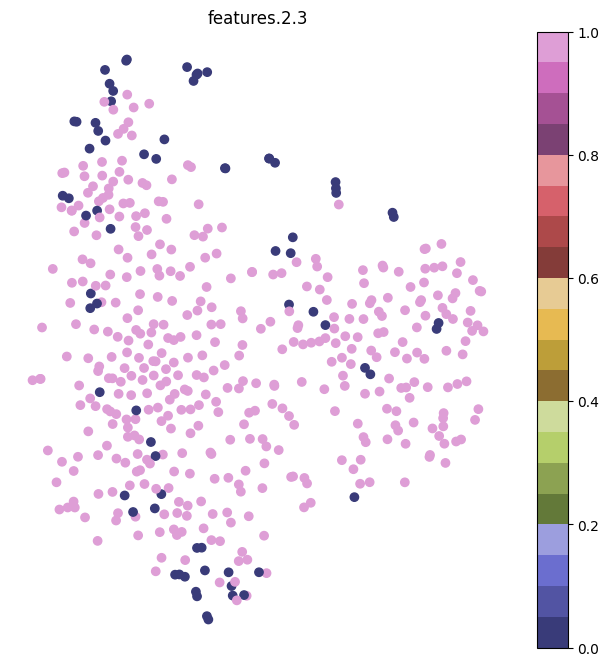

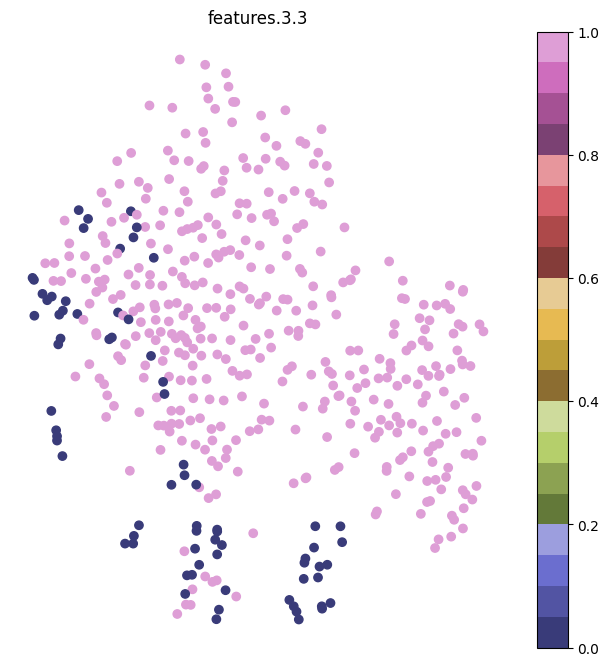

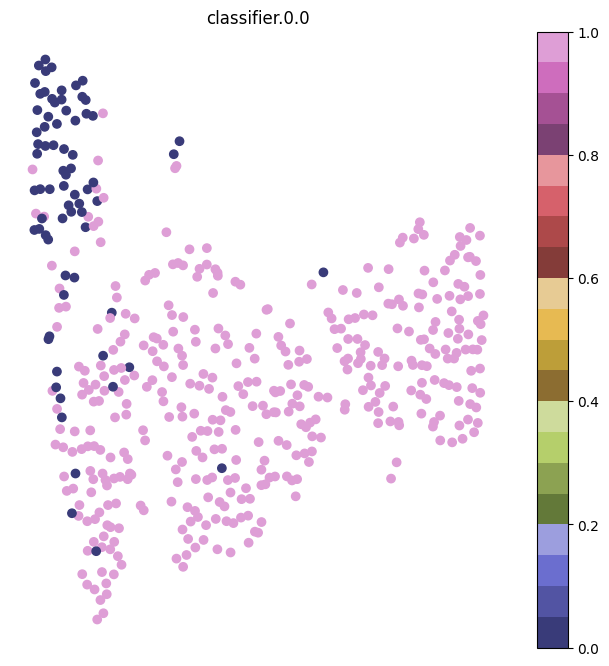

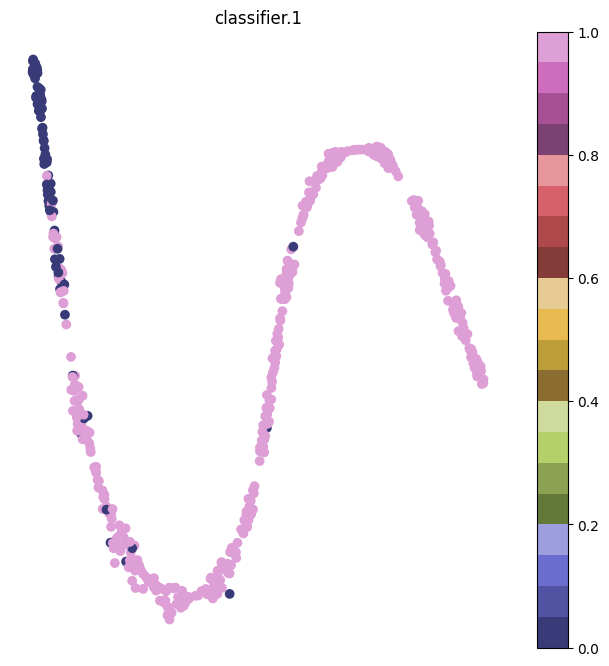

In [28]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


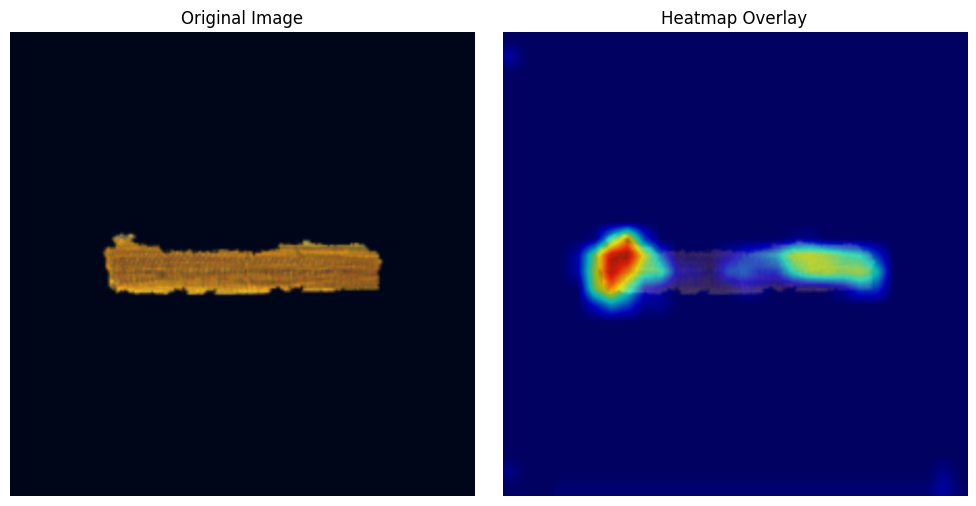

  Generating heatmap for Larvae...
  Predicted label is Larvae!


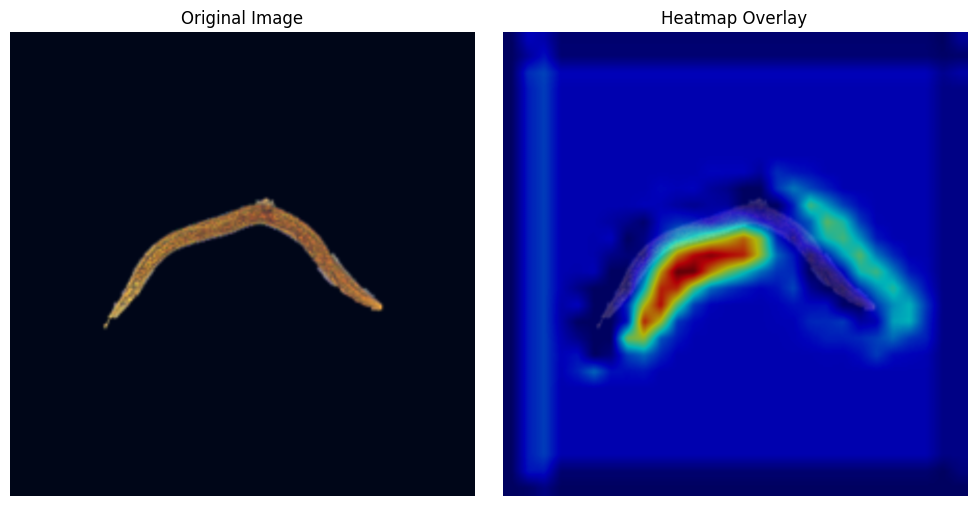

In [29]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [30]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32,128],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          36,864
      BatchNorm2d-14          [-1, 128,

In [31]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=3e-4)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=1e-5)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [32]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7311 | Val Loss: 0.6410 | Train cohen_kappa_fn: 0.1095 | Val cohen_kappa_fn: 0.1091 | Train accuracy_fn: 0.4468 | Val accuracy_fn: 0.4295
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6264 | Val Loss: 0.5372 | Train cohen_kappa_fn: 0.2918 | Val cohen_kappa_fn: 0.4490 | Train accuracy_fn: 0.7046 | Val accuracy_fn: 0.8652
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5336 | Val Loss: 0.5350 | Train cohen_kappa_fn: 0.4445 | Val cohen_kappa_fn: 0.4402 | Train accuracy_fn: 0.8586 | Val accuracy_fn: 0.8903
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4731 | Val Loss: 0.4852 | Train cohen_kappa_fn: 0.5429 | Val cohen_kappa_fn: 0.4838 | Train accuracy_fn: 0.8836 | Val accuracy_fn: 0.8966
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4260 | Val Loss: 0.3616 | Train cohen_kappa_fn: 0.6117 | Val cohen_kappa_fn: 0.7206 | Train accuracy_fn: 0.8949 | Val accuracy_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4246 | Val Loss: 0.4996 | Train cohen_kappa_fn: 0.2178 | Val cohen_kappa_fn: 0.1689 | Train accuracy_fn: 0.5507 | Val accuracy_fn: 0.4953
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.3721 | Val Loss: 0.2716 | Train cohen_kappa_fn: 0.5834 | Val cohen_kappa_fn: 0.6322 | Train accuracy_fn: 0.8486 | Val accuracy_fn: 0.8840
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3237 | Val Loss: 0.3393 | Train cohen_kappa_fn: 0.3306 | Val cohen_kappa_fn: 0.4142 | Train accuracy_fn: 0.6758 | Val accuracy_fn: 0.7492
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2740 | Val Loss: 0.2015 | Train cohen_kappa_fn: 0.6884 | Val cohen_kappa_fn: 0.7375 | Train accuracy_fn: 0.9024 | Val accuracy_fn: 0.9248
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2509 | Val Loss: 0.1778 | Train cohen_kappa_fn: 0.7305 | Val cohen_kappa_fn: 0.7630 | Train accuracy_fn: 0.9174 | Val accuracy_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2151 | Val Loss: 0.1942 | Train cohen_kappa_fn: 0.7459 | Val cohen_kappa_fn: 0.8078 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.9530
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2172 | Val Loss: 0.1803 | Train cohen_kappa_fn: 0.7029 | Val cohen_kappa_fn: 0.6919 | Train accuracy_fn: 0.9024 | Val accuracy_fn: 0.9028
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1872 | Val Loss: 0.1776 | Train cohen_kappa_fn: 0.7198 | Val cohen_kappa_fn: 0.6919 | Train accuracy_fn: 0.9086 | Val accuracy_fn: 0.9028
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2152 | Val Loss: 0.1681 | Train cohen_kappa_fn: 0.7615 | Val cohen_kappa_fn: 0.7839 | Train accuracy_fn: 0.9312 | Val accuracy_fn: 0.9404
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2034 | Val Loss: 0.1632 | Train cohen_kappa_fn: 0.8243 | Val cohen_kappa_fn: 0.8685 | Train accuracy_fn: 0.9487 | Val accuracy_fn: 0.9655
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1681 | Val Loss: 0.4268 | Train cohen_kappa_fn: 0.7945 | Val cohen_kappa_fn: 0.7439 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9436
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1837 | Val Loss: 0.2997 | Train cohen_kappa_fn: 0.4683 | Val cohen_kappa_fn: 0.5209 | Train accuracy_fn: 0.7760 | Val accuracy_fn: 0.8182
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1998 | Val Loss: 0.1683 | Train cohen_kappa_fn: 0.8621 | Val cohen_kappa_fn: 0.8640 | Train accuracy_fn: 0.9637 | Val accuracy_fn: 0.9655
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1635 | Val Loss: 0.1555 | Train cohen_kappa_fn: 0.7877 | Val cohen_kappa_fn: 0.7491 | Train accuracy_fn: 0.9349 | Val accuracy_fn: 0.9248
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1314 | Val Loss: 0.1422 | Train cohen_kappa_fn: 0.7865 | Val cohen_kappa_fn: 0.7755 | Train accuracy_fn: 0.9337 | Val accuracy_fn: 0.9342
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.1100 | Val Loss: 0.1800 | Train cohen_kappa_fn: 0.8964 | Val cohen_kappa_fn: 0.8503 | Train accuracy_fn: 0.9725 | Val accuracy_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1270 | Val Loss: 0.1333 | Train cohen_kappa_fn: 0.8806 | Val cohen_kappa_fn: 0.8707 | Train accuracy_fn: 0.9675 | Val accuracy_fn: 0.9655
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1316 | Val Loss: 0.1527 | Train cohen_kappa_fn: 0.8655 | Val cohen_kappa_fn: 0.8663 | Train accuracy_fn: 0.9650 | Val accuracy_fn: 0.9655
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1468 | Val Loss: 0.1746 | Train cohen_kappa_fn: 0.8995 | Val cohen_kappa_fn: 0.8887 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9718
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1359 | Val Loss: 0.1975 | Train cohen_kappa_fn: 0.7351 | Val cohen_kappa_fn: 0.6765 | Train accuracy_fn: 0.9136 | Val accuracy_fn: 0.8966
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1306 | Val Loss: 0.1363 | Train cohen_kappa_fn: 0.8122 | Val cohen_kappa_fn: 0.7938 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9404
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1223 | Val Loss: 0.1316 | Train cohen_kappa_fn: 0.8764 | Val cohen_kappa_fn: 0.8578 | Train accuracy_fn: 0.9662 | Val accuracy_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.1242 | Val Loss: 0.1234 | Train cohen_kappa_fn: 0.8842 | Val cohen_kappa_fn: 0.8601 | Train accuracy_fn: 0.9675 | Val accuracy_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1268 | Val Loss: 0.1513 | Train cohen_kappa_fn: 0.8051 | Val cohen_kappa_fn: 0.7755 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9342
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1102 | Val Loss: 0.1498 | Train cohen_kappa_fn: 0.8552 | Val cohen_kappa_fn: 0.8795 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9687
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1185 | Val Loss: 0.2229 | Train cohen_kappa_fn: 0.6439 | Val cohen_kappa_fn: 0.6471 | Train accuracy_fn: 0.8736 | Val accuracy_fn: 0.8840
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1181 | Val Loss: 0.1595 | Train cohen_kappa_fn: 0.7751 | Val cohen_kappa_fn: 0.7666 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.9310
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1051 | Val Loss: 0.1460 | Train cohen_kappa_fn: 0.8168 | Val cohen_kappa_fn: 0.7938 | Train accuracy_fn: 0.9437 | Val accuracy_fn: 0.9404
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


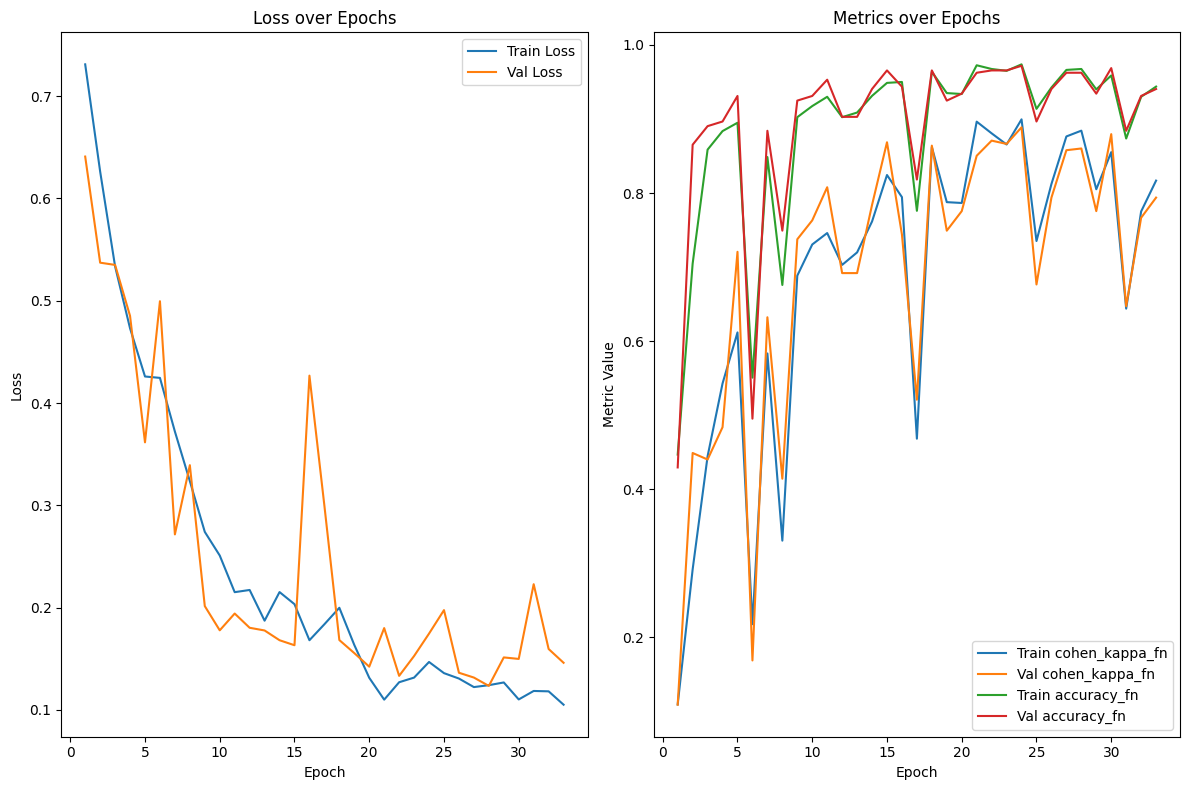

In [33]:
trainer_cnn_3.plot_epochs()

In [34]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2035 | Test cohen_kappa_fn: 0.7876 | Test accuracy_fn: 0.9458


#### Visualization

In [35]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

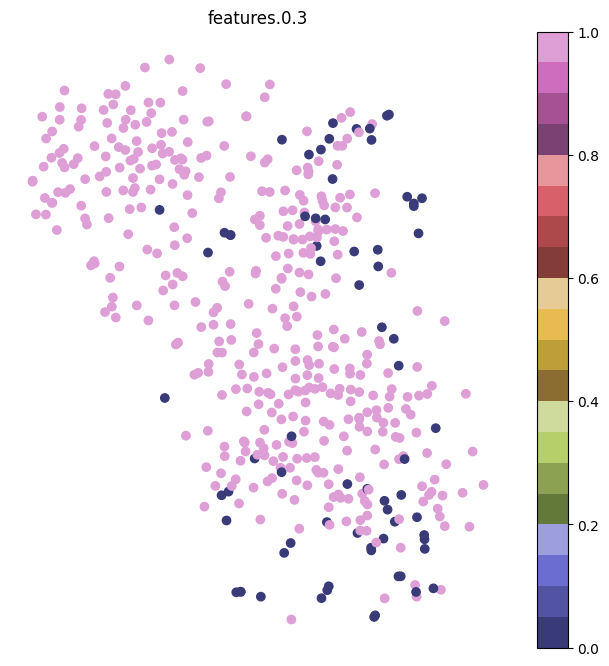

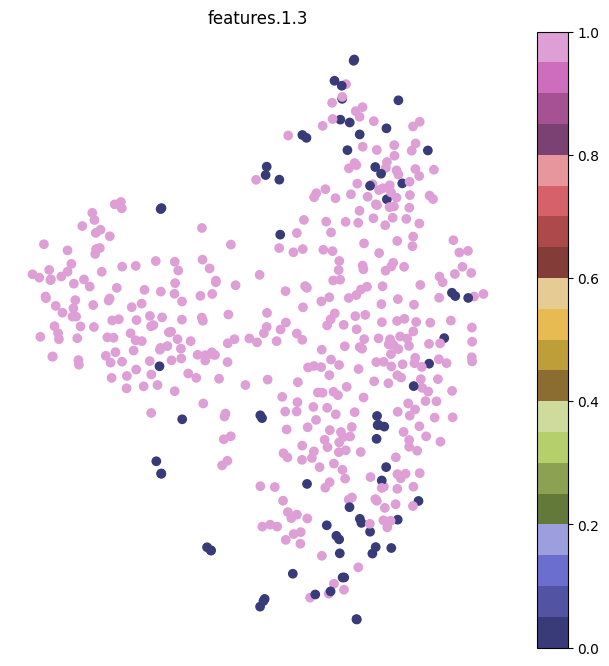

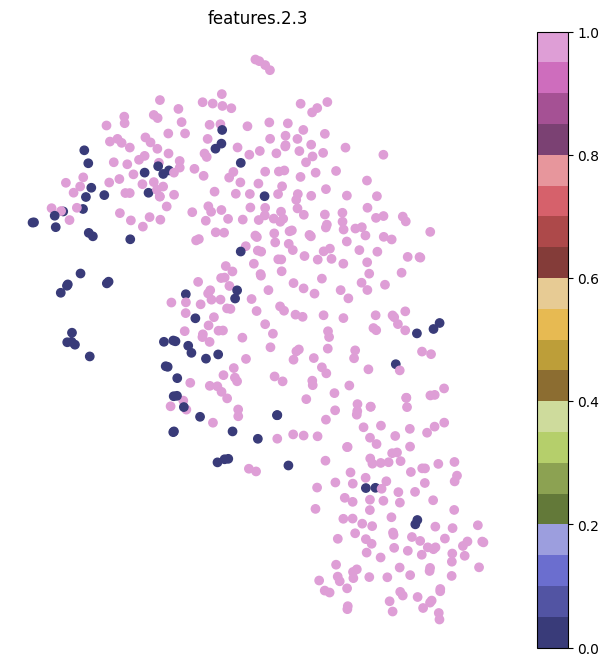

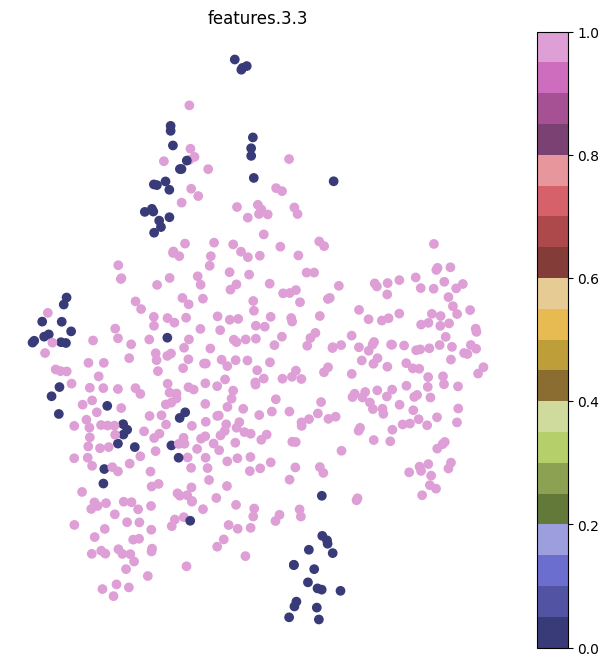

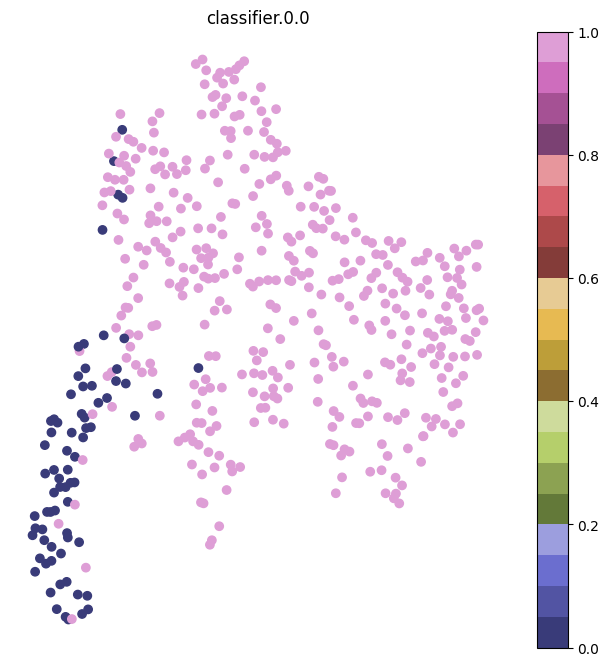

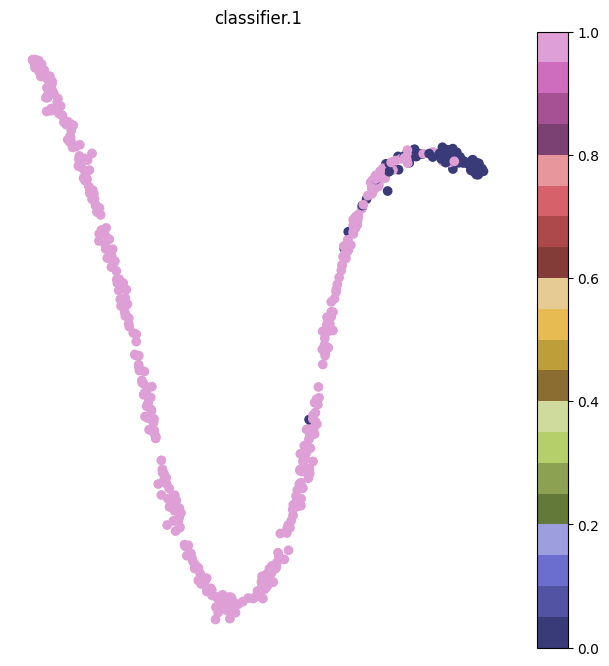

In [36]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


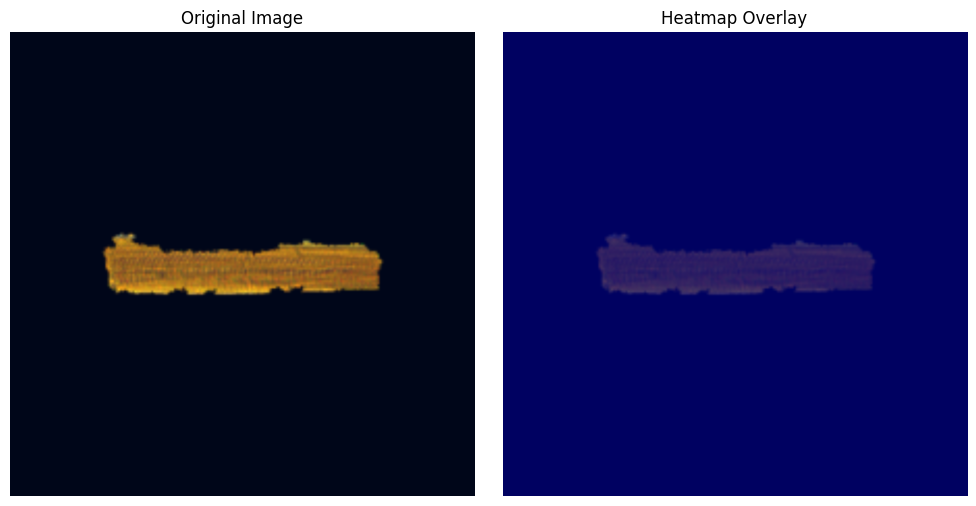

  Generating heatmap for Larvae...
  Predicted label is Larvae!


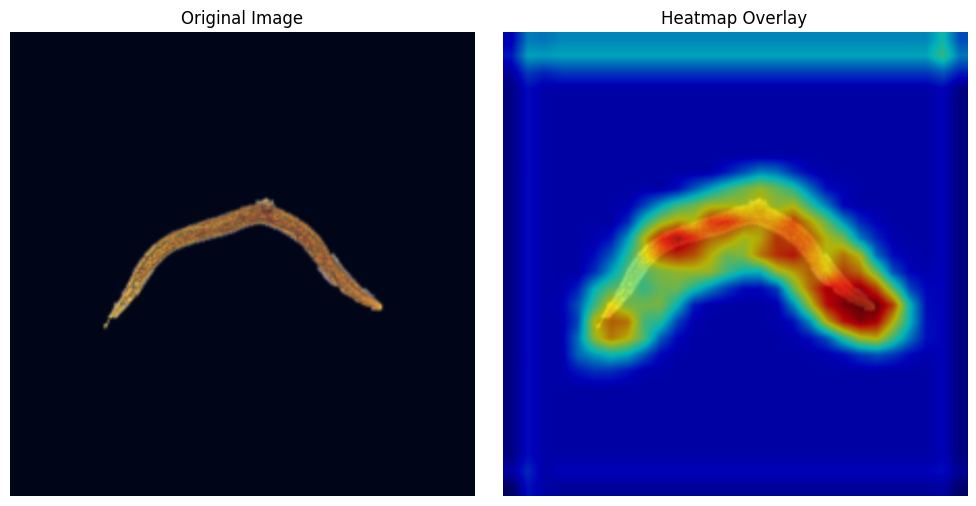

In [37]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [38]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,16],
    conv_channels=[8,16,32,128],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          36,864
      BatchNorm2d-14          [-1, 128,

In [39]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=3e-4)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=1e-5)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [40]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6929 | Val Loss: 0.6851 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8398 | Val accuracy_fn: 0.8527
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6591 | Val Loss: 0.6286 | Train cohen_kappa_fn: 0.2208 | Val cohen_kappa_fn: 0.1103 | Train accuracy_fn: 0.6558 | Val accuracy_fn: 0.7273
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6010 | Val Loss: 0.5000 | Train cohen_kappa_fn: 0.2634 | Val cohen_kappa_fn: 0.3659 | Train accuracy_fn: 0.6508 | Val accuracy_fn: 0.7524
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5353 | Val Loss: 0.4405 | Train cohen_kappa_fn: 0.3911 | Val cohen_kappa_fn: 0.6474 | Train accuracy_fn: 0.7647 | Val accuracy_fn: 0.9028
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4525 | Val Loss: 0.3272 | Train cohen_kappa_fn: 0.4966 | Val cohen_kappa_fn: 0.7066 | Train accuracy_fn: 0.8110 | Val accuracy_fn: 0.9185
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4030 | Val Loss: 0.3324 | Train cohen_kappa_fn: 0.5709 | Val cohen_kappa_fn: 0.7490 | Train accuracy_fn: 0.8648 | Val accuracy_fn: 0.9342
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.3374 | Val Loss: 0.4202 | Train cohen_kappa_fn: 0.2531 | Val cohen_kappa_fn: 0.2718 | Train accuracy_fn: 0.5945 | Val accuracy_fn: 0.6238
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.3282 | Val Loss: 0.2560 | Train cohen_kappa_fn: 0.7484 | Val cohen_kappa_fn: 0.7669 | Train accuracy_fn: 0.9287 | Val accuracy_fn: 0.9373
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2819 | Val Loss: 0.2681 | Train cohen_kappa_fn: 0.5519 | Val cohen_kappa_fn: 0.5746 | Train accuracy_fn: 0.8310 | Val accuracy_fn: 0.8527
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2921 | Val Loss: 0.2381 | Train cohen_kappa_fn: 0.7411 | Val cohen_kappa_fn: 0.7707 | Train accuracy_fn: 0.9262 | Val accuracy_fn: 0.9373
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2536 | Val Loss: 0.2721 | Train cohen_kappa_fn: 0.5205 | Val cohen_kappa_fn: 0.5264 | Train accuracy_fn: 0.8123 | Val accuracy_fn: 0.8276
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2725 | Val Loss: 0.2738 | Train cohen_kappa_fn: 0.7800 | Val cohen_kappa_fn: 0.7447 | Train accuracy_fn: 0.9374 | Val accuracy_fn: 0.9342
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2331 | Val Loss: 0.2514 | Train cohen_kappa_fn: 0.4794 | Val cohen_kappa_fn: 0.6124 | Train accuracy_fn: 0.7860 | Val accuracy_fn: 0.8683
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2255 | Val Loss: 0.2418 | Train cohen_kappa_fn: 0.6003 | Val cohen_kappa_fn: 0.6954 | Train accuracy_fn: 0.8561 | Val accuracy_fn: 0.9060
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2122 | Val Loss: 0.2330 | Train cohen_kappa_fn: 0.6091 | Val cohen_kappa_fn: 0.6797 | Train accuracy_fn: 0.8586 | Val accuracy_fn: 0.8997
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1896 | Val Loss: 0.3126 | Train cohen_kappa_fn: 0.8346 | Val cohen_kappa_fn: 0.6998 | Train accuracy_fn: 0.9562 | Val accuracy_fn: 0.9279
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1863 | Val Loss: 0.3553 | Train cohen_kappa_fn: 0.4530 | Val cohen_kappa_fn: 0.4409 | Train accuracy_fn: 0.7672 | Val accuracy_fn: 0.7680
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1900 | Val Loss: 0.1928 | Train cohen_kappa_fn: 0.7618 | Val cohen_kappa_fn: 0.7649 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.9342
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1821 | Val Loss: 0.1971 | Train cohen_kappa_fn: 0.8109 | Val cohen_kappa_fn: 0.7839 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9404
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1395 | Val Loss: 0.2127 | Train cohen_kappa_fn: 0.7807 | Val cohen_kappa_fn: 0.7504 | Train accuracy_fn: 0.9324 | Val accuracy_fn: 0.9279
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1878 | Val Loss: 0.1981 | Train cohen_kappa_fn: 0.7783 | Val cohen_kappa_fn: 0.7649 | Train accuracy_fn: 0.9324 | Val accuracy_fn: 0.9342
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2053 | Val Loss: 0.2156 | Train cohen_kappa_fn: 0.6925 | Val cohen_kappa_fn: 0.7594 | Train accuracy_fn: 0.8974 | Val accuracy_fn: 0.9310
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1360 | Val Loss: 0.2003 | Train cohen_kappa_fn: 0.6721 | Val cohen_kappa_fn: 0.7116 | Train accuracy_fn: 0.8886 | Val accuracy_fn: 0.9122
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


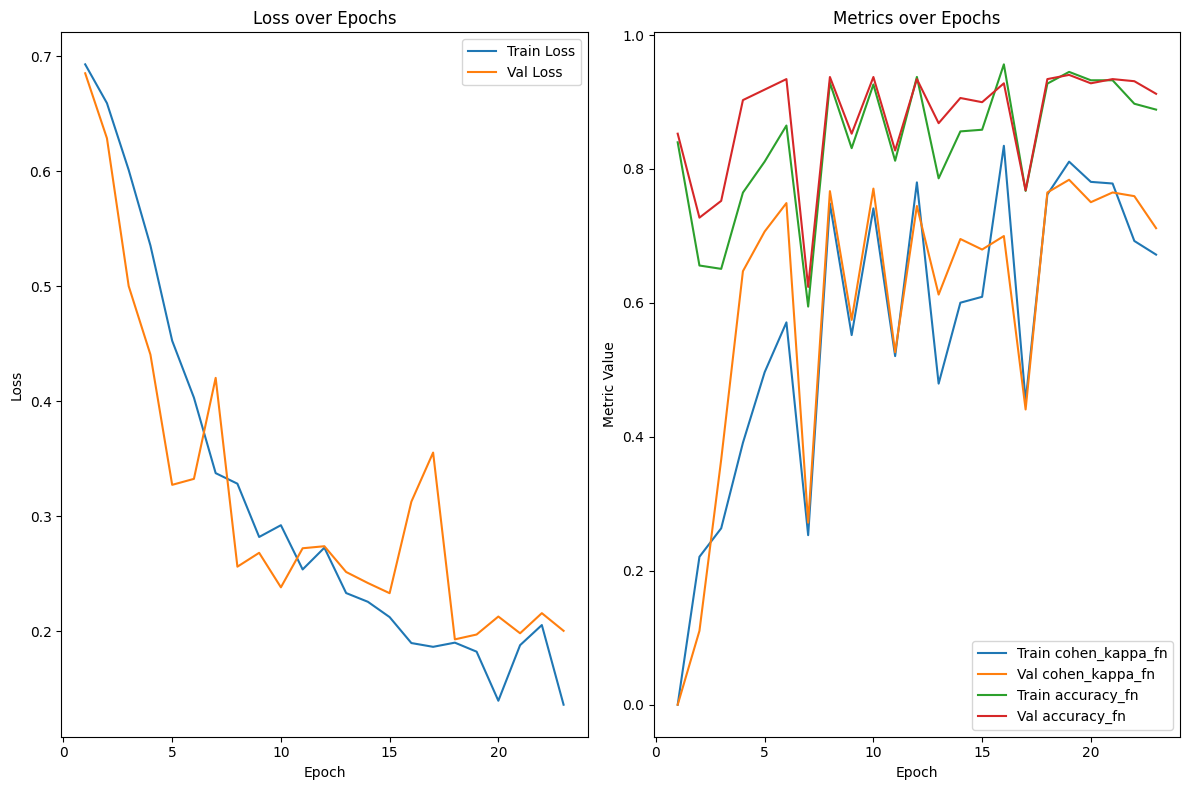

In [41]:
trainer_cnn_4.plot_epochs()

In [42]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2660 | Test cohen_kappa_fn: 0.6783 | Test accuracy_fn: 0.9062


#### Visualization

In [43]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

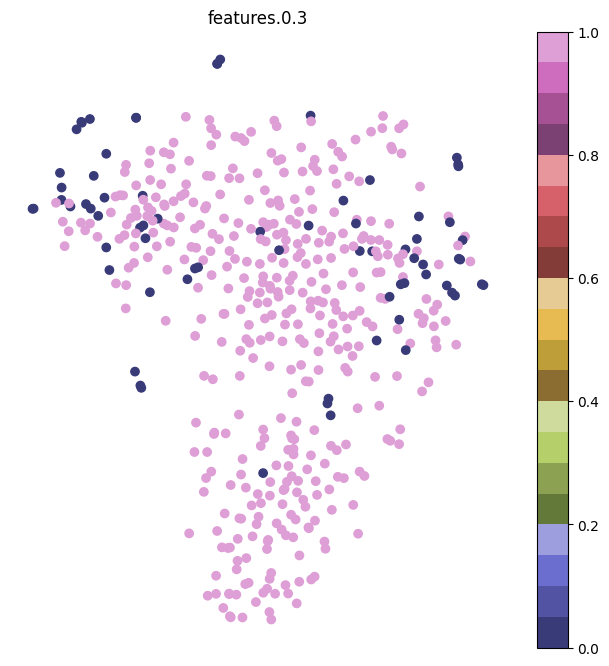

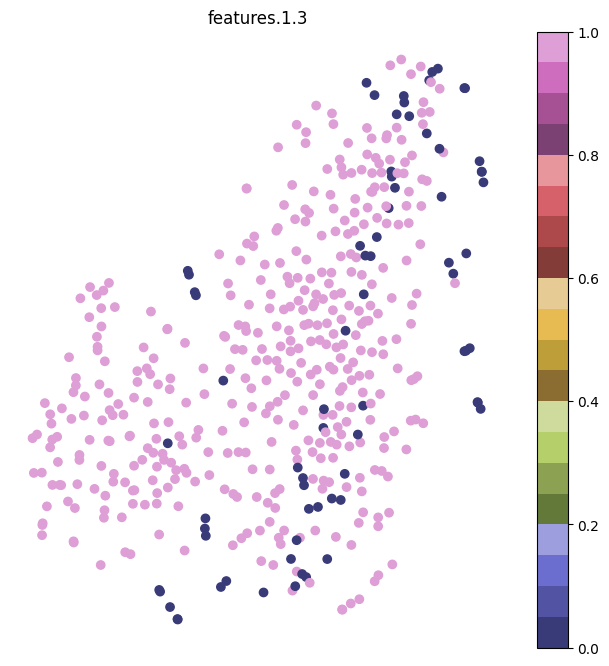

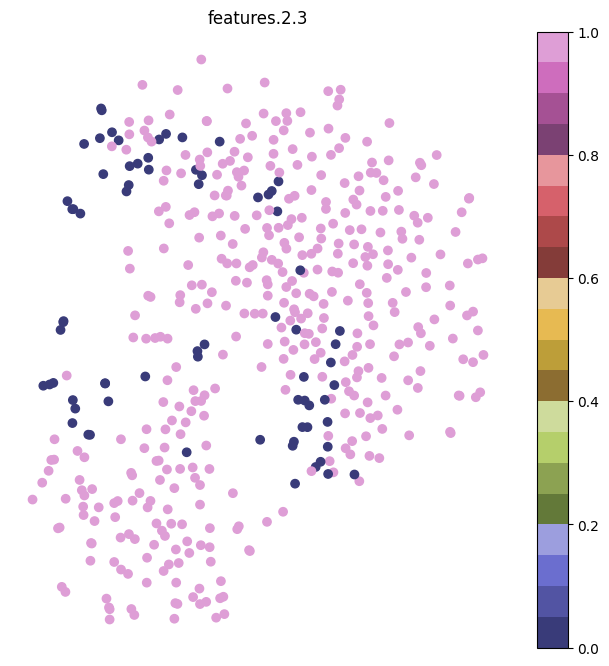

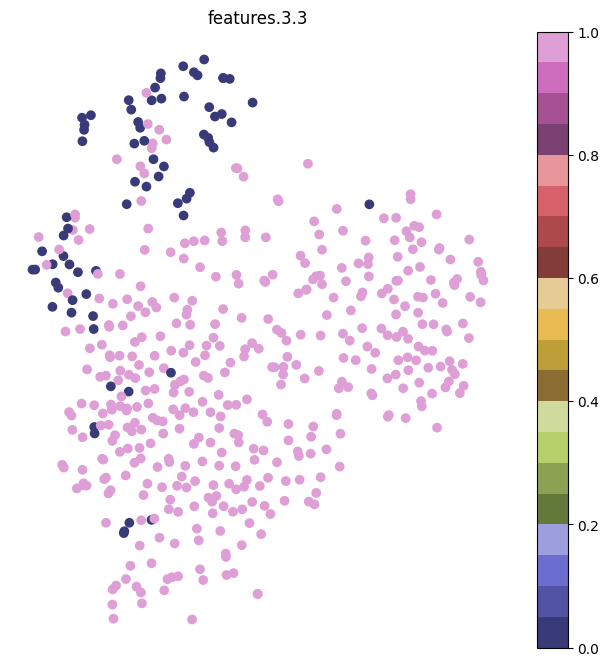

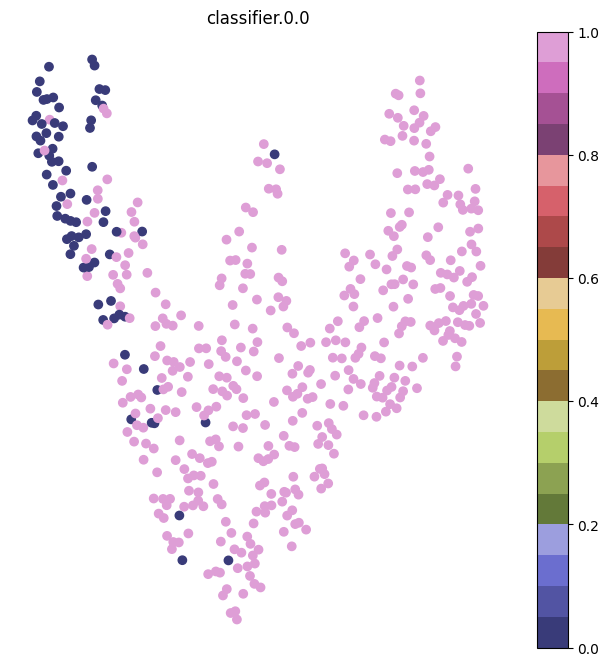

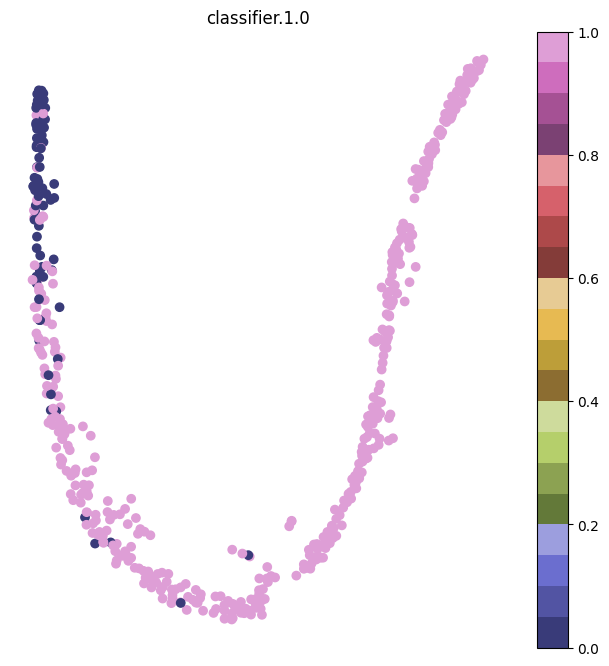

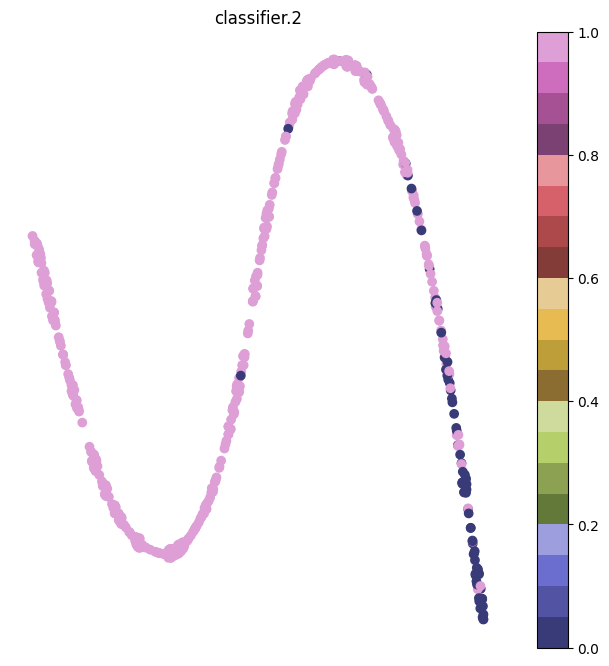

In [44]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


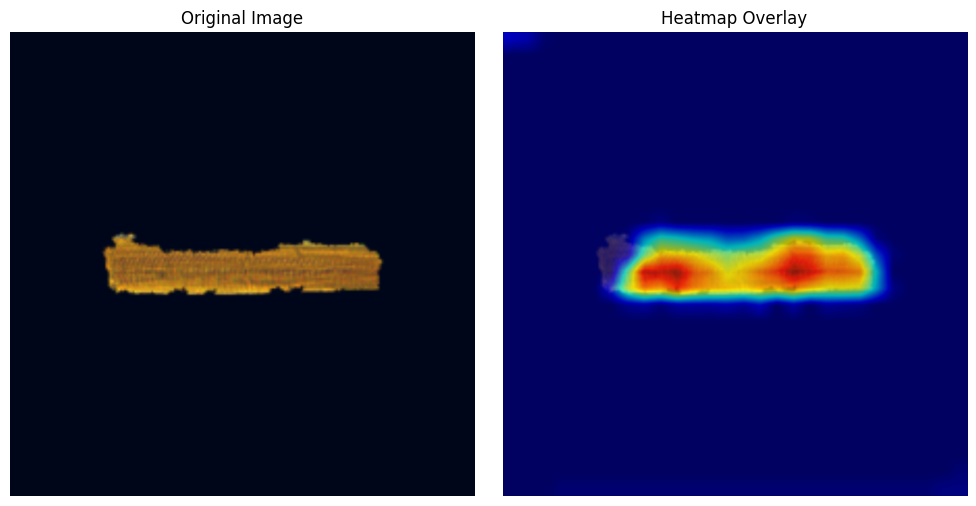

  Generating heatmap for Larvae...
  Predicted label is Larvae!


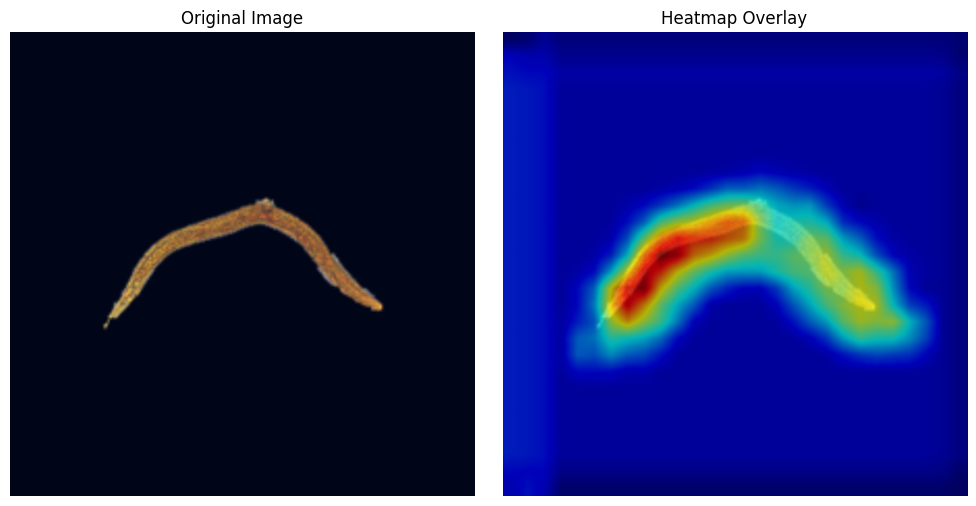

In [45]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [46]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,64,256],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         147,456
      BatchNorm2d-14          [-1, 256,

In [47]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=3e-4)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=1e-5)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [48]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6968 | Val Loss: 0.6912 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8398 | Val accuracy_fn: 0.8527
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 2 | Train Loss: 0.6874 | Val Loss: 0.6786 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8398 | Val accuracy_fn: 0.8527
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6634 | Val Loss: 0.6255 | Train cohen_kappa_fn: 0.1741 | Val cohen_kappa_fn: 0.1658 | Train accuracy_fn: 0.5031 | Val accuracy_fn: 0.5266
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5318 | Val Loss: 0.4201 | Train cohen_kappa_fn: 0.3026 | Val cohen_kappa_fn: 0.3466 | Train accuracy_fn: 0.6546 | Val accuracy_fn: 0.7116
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4460 | Val Loss: 0.6481 | Train cohen_kappa_fn: 0.0851 | Val cohen_kappa_fn: 0.0992 | Train accuracy_fn: 0.3492 | Val accuracy_fn: 0.3793
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3835 | Val Loss: 0.2418 | Train cohen_kappa_fn: 0.6870 | Val cohen_kappa_fn: 0.7729 | Train accuracy_fn: 0.9011 | Val accuracy_fn: 0.9404
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2858 | Val Loss: 0.2157 | Train cohen_kappa_fn: 0.6334 | Val cohen_kappa_fn: 0.7287 | Train accuracy_fn: 0.8736 | Val accuracy_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2734 | Val Loss: 0.2981 | Train cohen_kappa_fn: 0.7803 | Val cohen_kappa_fn: 0.7768 | Train accuracy_fn: 0.9437 | Val accuracy_fn: 0.9498
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2314 | Val Loss: 0.1814 | Train cohen_kappa_fn: 0.6562 | Val cohen_kappa_fn: 0.7743 | Train accuracy_fn: 0.8824 | Val accuracy_fn: 0.9373
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2332 | Val Loss: 0.2399 | Train cohen_kappa_fn: 0.5017 | Val cohen_kappa_fn: 0.5549 | Train accuracy_fn: 0.7972 | Val accuracy_fn: 0.8370
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2417 | Val Loss: 0.1772 | Train cohen_kappa_fn: 0.7231 | Val cohen_kappa_fn: 0.7839 | Train accuracy_fn: 0.9111 | Val accuracy_fn: 0.9404
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1925 | Val Loss: 0.1575 | Train cohen_kappa_fn: 0.7807 | Val cohen_kappa_fn: 0.8237 | Train accuracy_fn: 0.9324 | Val accuracy_fn: 0.9530
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1559 | Val Loss: 0.1497 | Train cohen_kappa_fn: 0.6794 | Val cohen_kappa_fn: 0.7936 | Train accuracy_fn: 0.8911 | Val accuracy_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1743 | Val Loss: 0.1508 | Train cohen_kappa_fn: 0.6999 | Val cohen_kappa_fn: 0.8554 | Train accuracy_fn: 0.9011 | Val accuracy_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1512 | Val Loss: 0.2852 | Train cohen_kappa_fn: 0.8489 | Val cohen_kappa_fn: 0.8389 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1778 | Val Loss: 0.6968 | Train cohen_kappa_fn: 0.8150 | Val cohen_kappa_fn: 0.6089 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9216
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1721 | Val Loss: 0.3853 | Train cohen_kappa_fn: 0.8566 | Val cohen_kappa_fn: 0.8047 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9561
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1624 | Val Loss: 0.1551 | Train cohen_kappa_fn: 0.6547 | Val cohen_kappa_fn: 0.7415 | Train accuracy_fn: 0.8786 | Val accuracy_fn: 0.9248
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


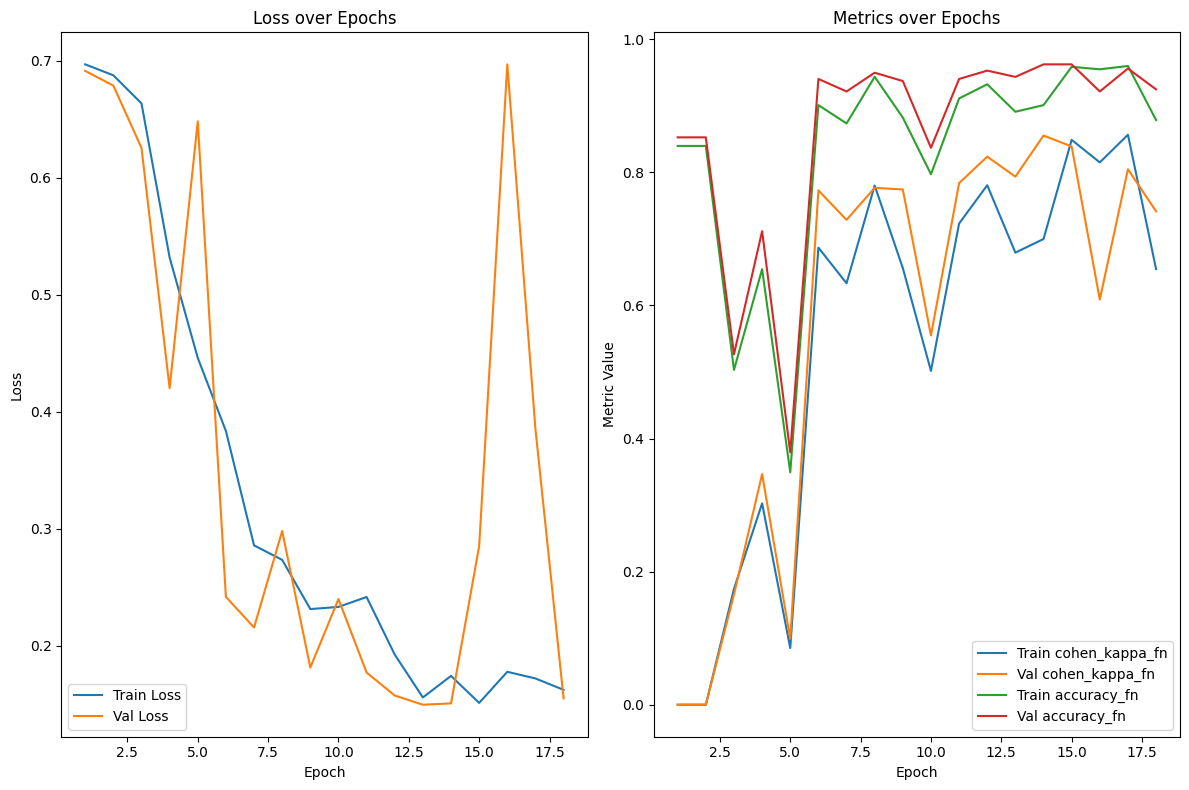

In [49]:
trainer_cnn_5.plot_epochs()

In [50]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2957 | Test cohen_kappa_fn: 0.6706 | Test accuracy_fn: 0.9021


#### Visualization

In [51]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

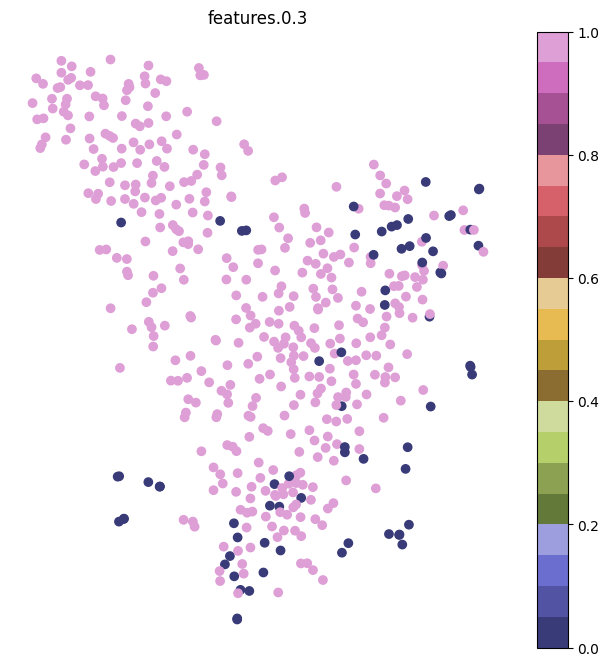

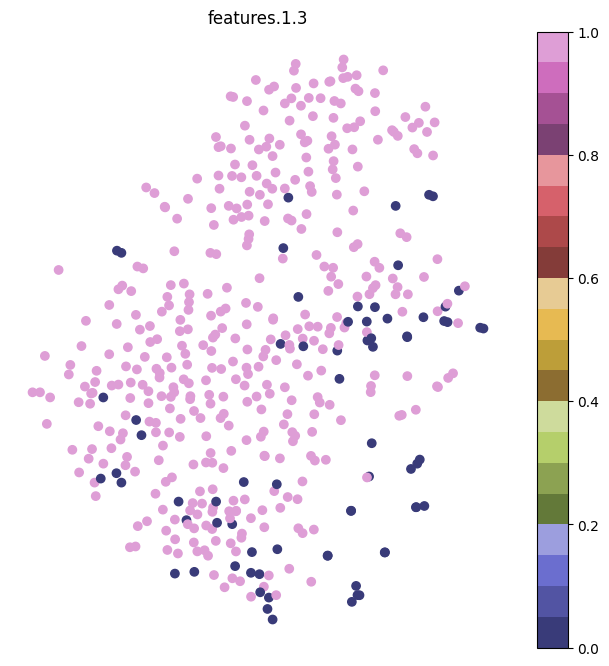

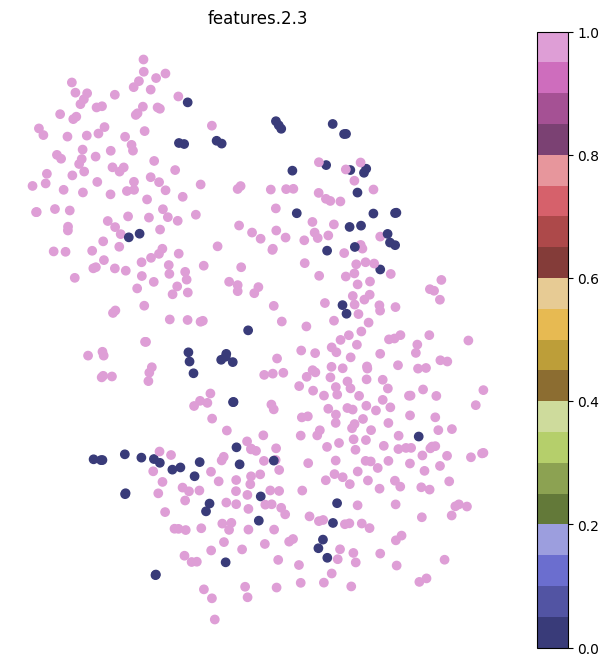

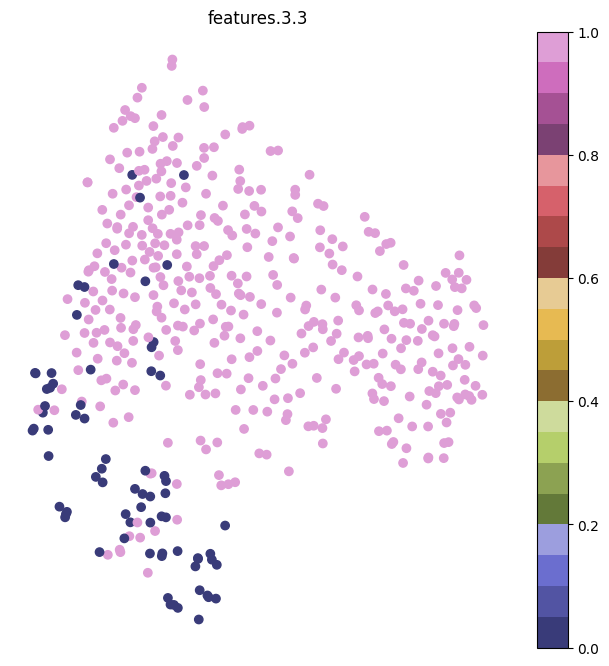

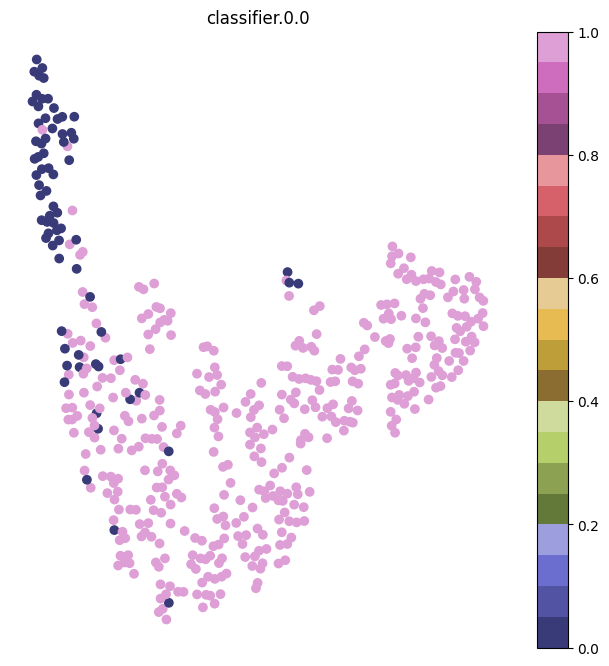

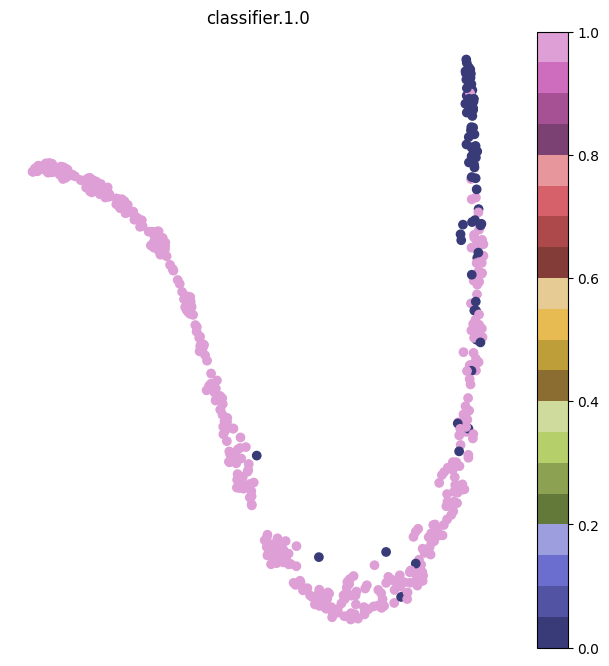

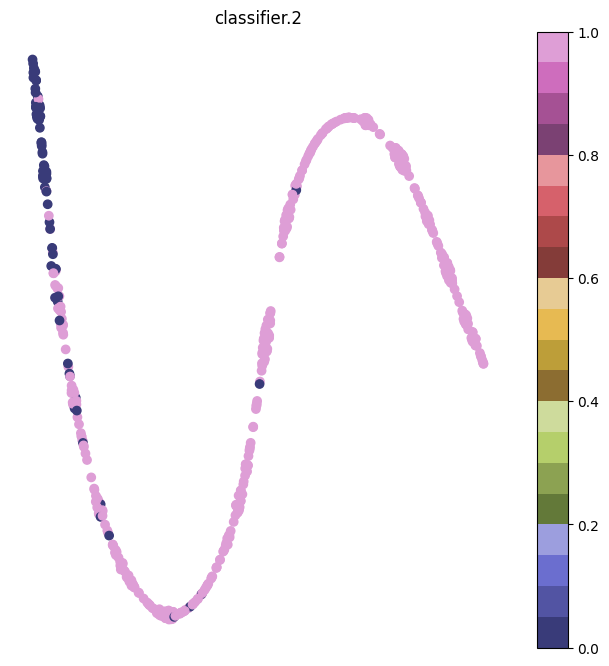

In [52]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


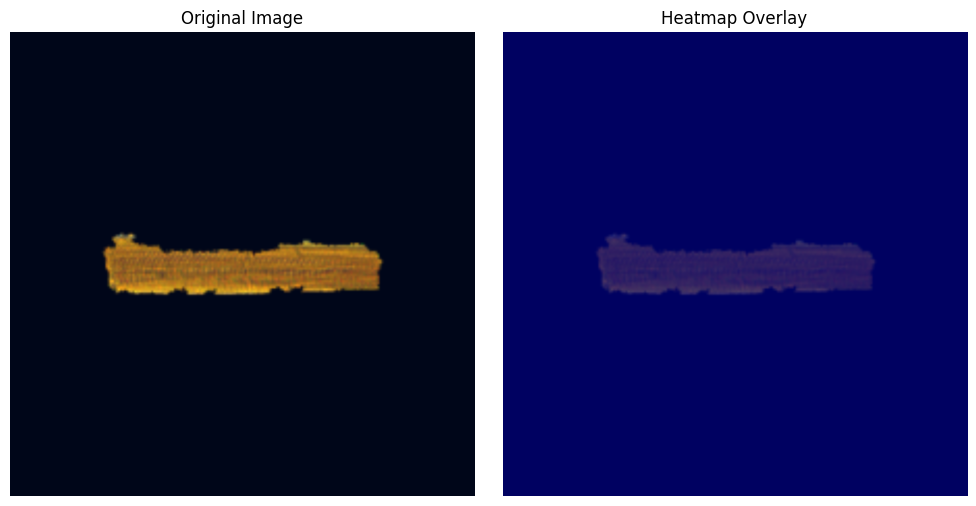

  Generating heatmap for Larvae...
  Predicted label is Larvae!


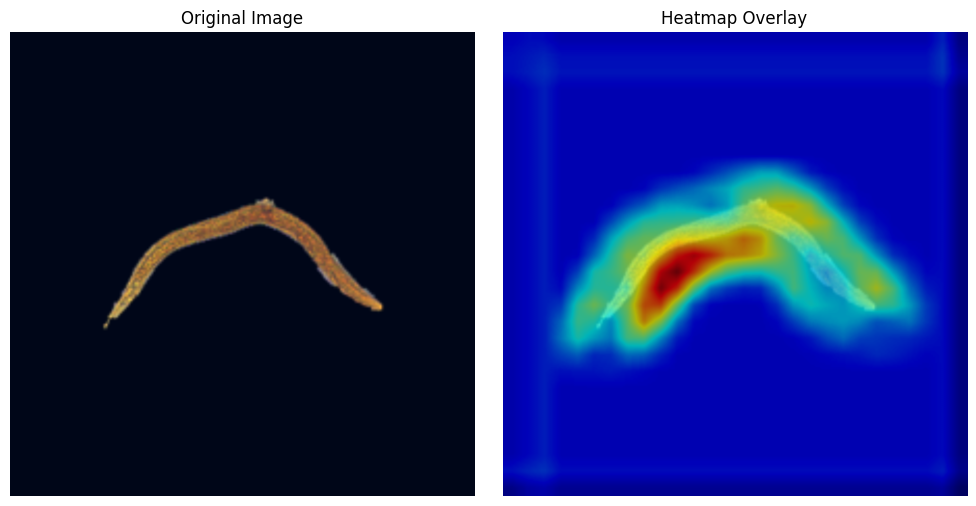

In [53]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [54]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,64,256,512],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         147,456
      BatchNorm2d-14          [-1, 256,

In [55]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=3e-4)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=1e-5)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [56]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6877 | Val Loss: 0.6732 | Train cohen_kappa_fn: 0.0692 | Val cohen_kappa_fn: -0.0122 | Train accuracy_fn: 0.8398 | Val accuracy_fn: 0.8464
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6061 | Val Loss: 0.5976 | Train cohen_kappa_fn: 0.2976 | Val cohen_kappa_fn: 0.2309 | Train accuracy_fn: 0.6521 | Val accuracy_fn: 0.5925
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.4552 | Val Loss: 0.3442 | Train cohen_kappa_fn: 0.4401 | Val cohen_kappa_fn: 0.3687 | Train accuracy_fn: 0.7722 | Val accuracy_fn: 0.7241
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4014 | Val Loss: 0.5167 | Train cohen_kappa_fn: 0.2137 | Val cohen_kappa_fn: 0.1980 | Train accuracy_fn: 0.5457 | Val accuracy_fn: 0.5361
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.2916 | Val Loss: 0.9893 | Train cohen_kappa_fn: 0.0671 | Val cohen_kappa_fn: 0.0430 | Train accuracy_fn: 0.3141 | Val accuracy_fn: 0.2602
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.2163 | Val Loss: 1.6967 | Train cohen_kappa_fn: 0.0078 | Val cohen_kappa_fn: 0.0193 | Train accuracy_fn: 0.1802 | Val accuracy_fn: 0.2006
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.2414 | Val Loss: 0.2384 | Train cohen_kappa_fn: 0.8195 | Val cohen_kappa_fn: 0.8419 | Train accuracy_fn: 0.9562 | Val accuracy_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.1749 | Val Loss: 0.1912 | Train cohen_kappa_fn: 0.6692 | Val cohen_kappa_fn: 0.7239 | Train accuracy_fn: 0.8874 | Val accuracy_fn: 0.9154
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1757 | Val Loss: 0.1707 | Train cohen_kappa_fn: 0.7090 | Val cohen_kappa_fn: 0.7491 | Train accuracy_fn: 0.9024 | Val accuracy_fn: 0.9248
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1797 | Val Loss: 0.2218 | Train cohen_kappa_fn: 0.5359 | Val cohen_kappa_fn: 0.7116 | Train accuracy_fn: 0.8210 | Val accuracy_fn: 0.9122
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1643 | Val Loss: 0.2424 | Train cohen_kappa_fn: 0.8743 | Val cohen_kappa_fn: 0.8042 | Train accuracy_fn: 0.9675 | Val accuracy_fn: 0.9530
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1684 | Val Loss: 0.2129 | Train cohen_kappa_fn: 0.6558 | Val cohen_kappa_fn: 0.6841 | Train accuracy_fn: 0.8798 | Val accuracy_fn: 0.8997
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1489 | Val Loss: 0.2110 | Train cohen_kappa_fn: 0.6229 | Val cohen_kappa_fn: 0.6543 | Train accuracy_fn: 0.8636 | Val accuracy_fn: 0.8871
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1512 | Val Loss: 0.2305 | Train cohen_kappa_fn: 0.6204 | Val cohen_kappa_fn: 0.6400 | Train accuracy_fn: 0.8623 | Val accuracy_fn: 0.8809
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


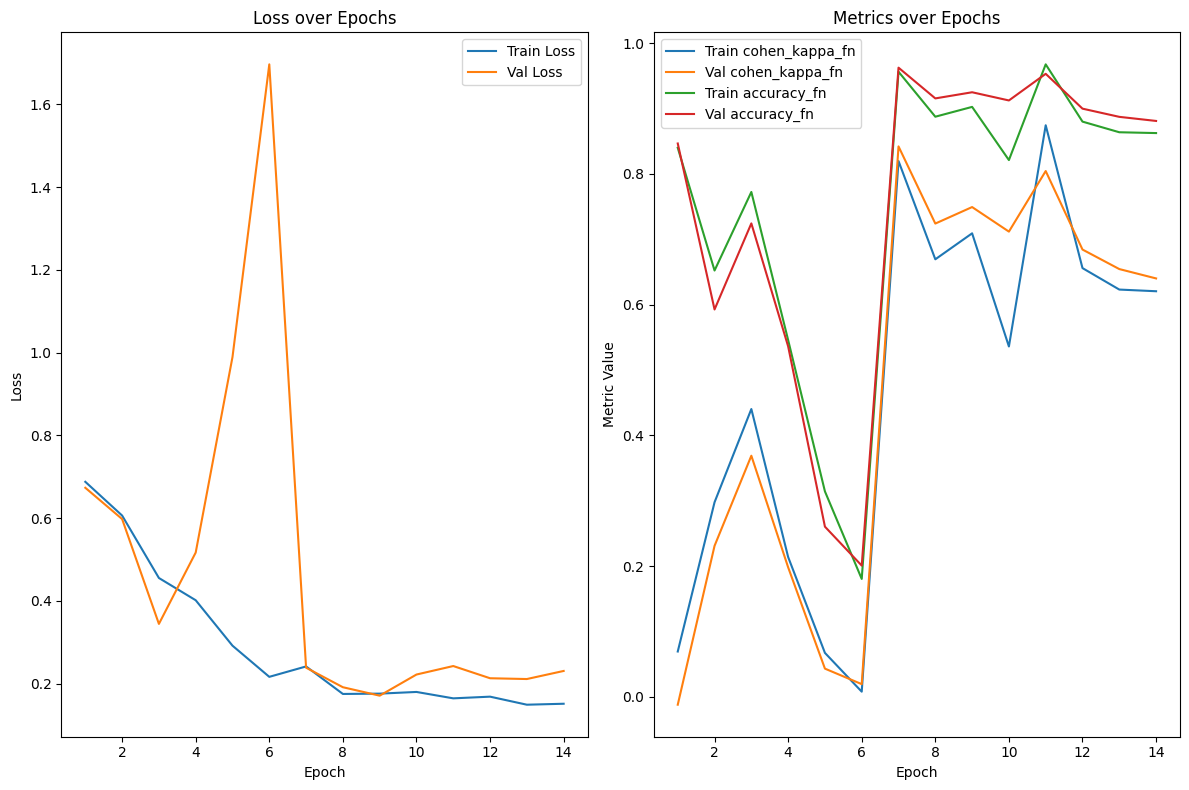

In [57]:
trainer_cnn_6.plot_epochs()

In [58]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1864 | Test cohen_kappa_fn: 0.6994 | Test accuracy_fn: 0.9062


#### Visualization

In [59]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

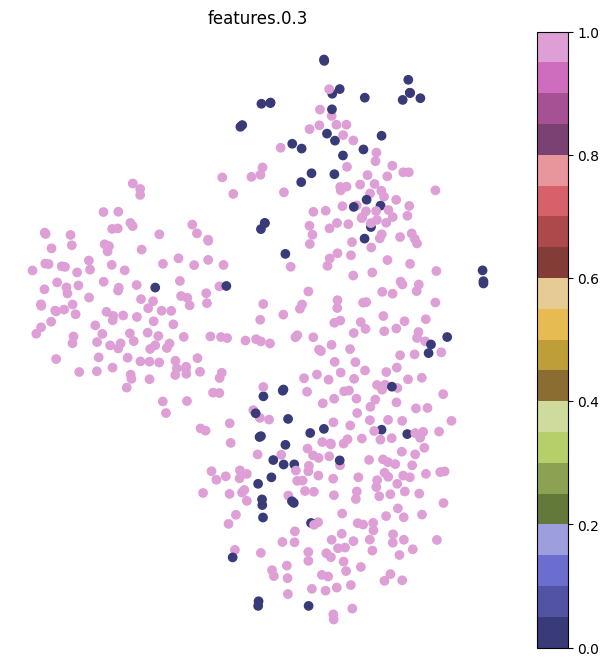

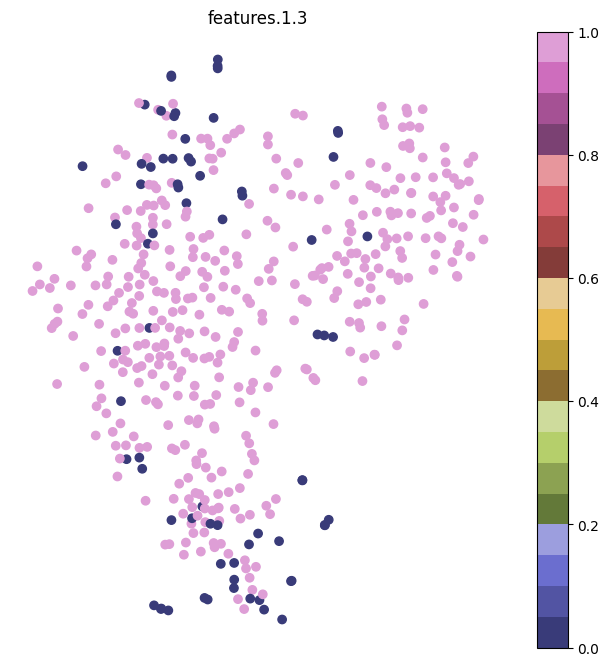

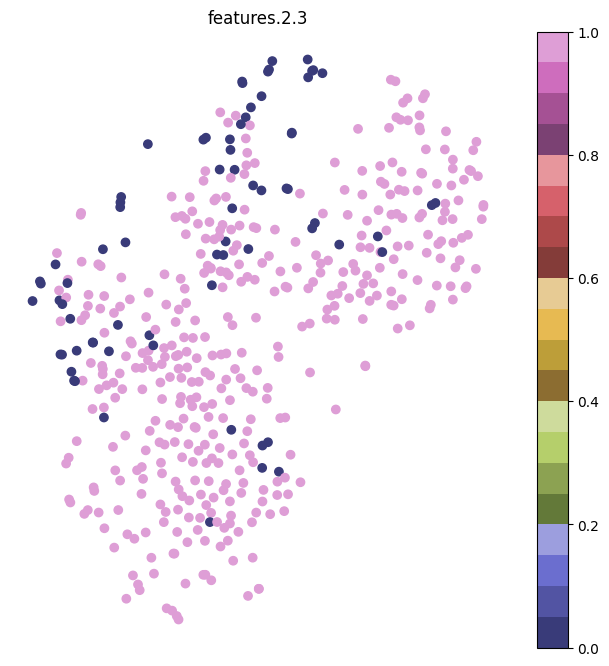

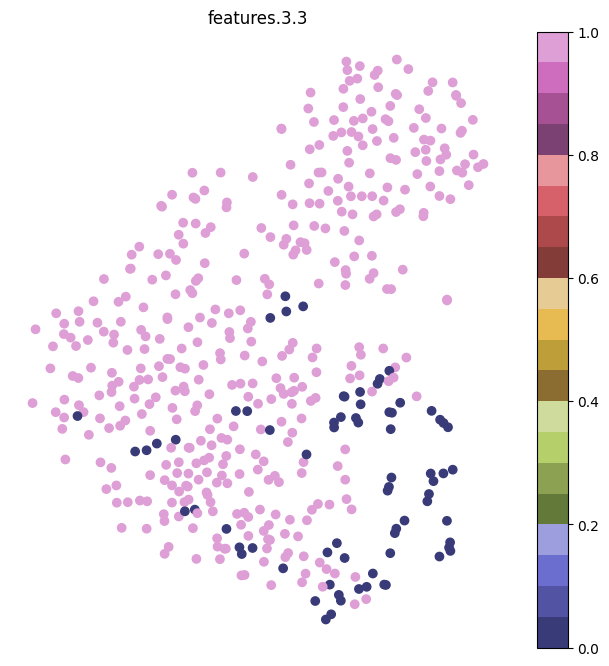

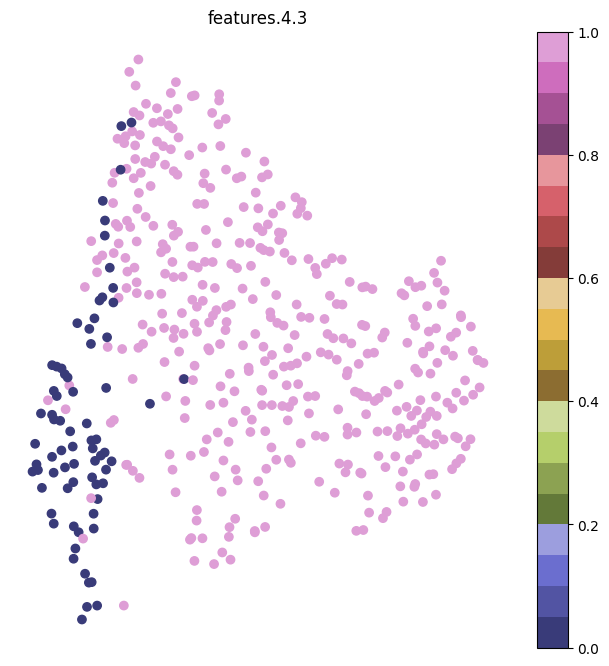

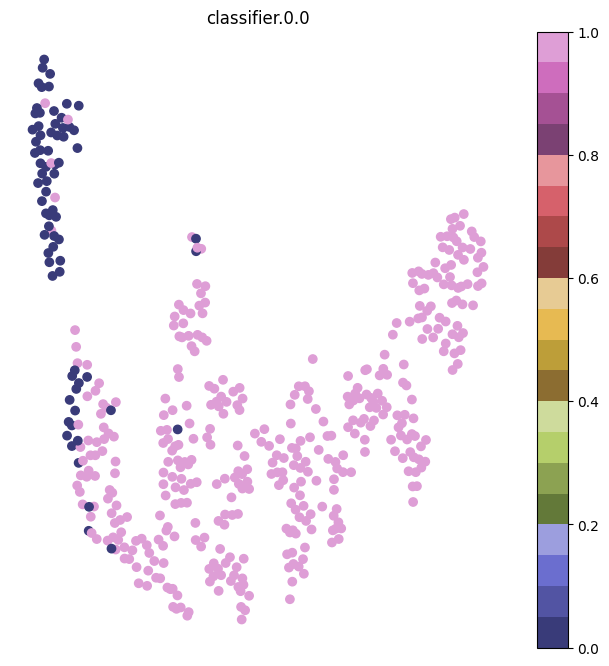

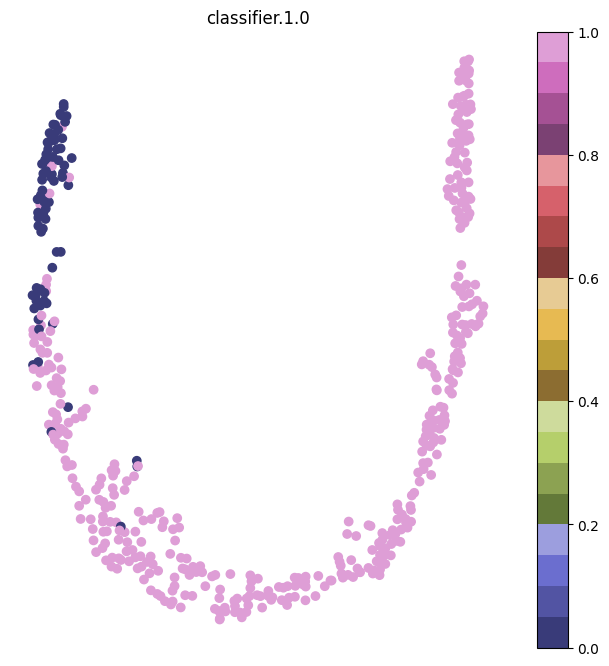

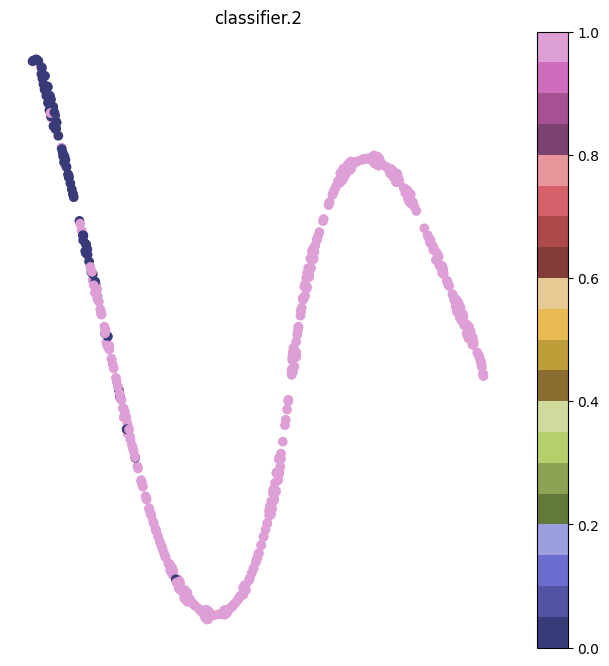

In [60]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


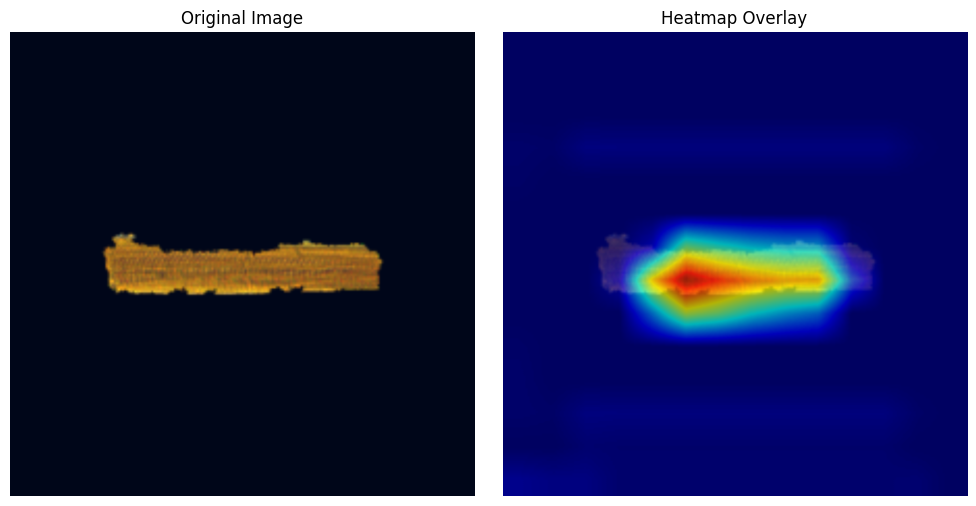

  Generating heatmap for Larvae...
  Predicted label is Larvae!


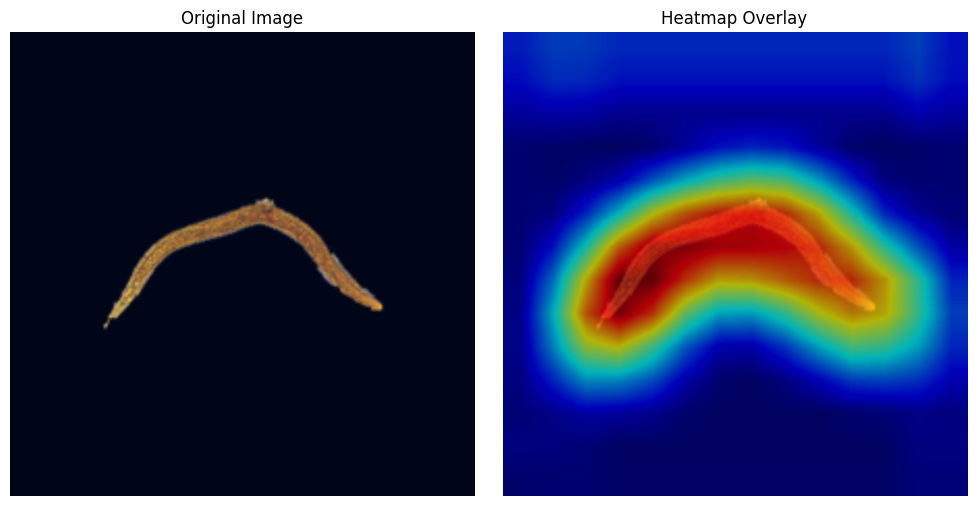

In [61]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [62]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,32,96,256],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          27,648
      BatchNorm2d-14           [-1, 96,

In [63]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=3e-4)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=1e-5)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [64]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6927 | Val Loss: 0.6912 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8398 | Val accuracy_fn: 0.8527
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6688 | Val Loss: 0.6284 | Train cohen_kappa_fn: 0.2628 | Val cohen_kappa_fn: 0.3142 | Train accuracy_fn: 0.7960 | Val accuracy_fn: 0.8307
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5998 | Val Loss: 0.5917 | Train cohen_kappa_fn: 0.1777 | Val cohen_kappa_fn: 0.1463 | Train accuracy_fn: 0.5207 | Val accuracy_fn: 0.4608
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5293 | Val Loss: 0.7708 | Train cohen_kappa_fn: 0.0696 | Val cohen_kappa_fn: 0.0365 | Train accuracy_fn: 0.3191 | Val accuracy_fn: 0.2445
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.4078 | Val Loss: 0.8162 | Train cohen_kappa_fn: 0.0946 | Val cohen_kappa_fn: 0.0511 | Train accuracy_fn: 0.3667 | Val accuracy_fn: 0.2790
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3418 | Val Loss: 0.3118 | Train cohen_kappa_fn: 0.5078 | Val cohen_kappa_fn: 0.4995 | Train accuracy_fn: 0.8060 | Val accuracy_fn: 0.8056
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2739 | Val Loss: 0.2863 | Train cohen_kappa_fn: 0.6042 | Val cohen_kappa_fn: 0.5436 | Train accuracy_fn: 0.8598 | Val accuracy_fn: 0.8339
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2540 | Val Loss: 0.7502 | Train cohen_kappa_fn: 0.2117 | Val cohen_kappa_fn: 0.1732 | Train accuracy_fn: 0.5432 | Val accuracy_fn: 0.5016
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2284 | Val Loss: 0.3563 | Train cohen_kappa_fn: 0.7017 | Val cohen_kappa_fn: 0.7605 | Train accuracy_fn: 0.9312 | Val accuracy_fn: 0.9467
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2047 | Val Loss: 0.3412 | Train cohen_kappa_fn: 0.4497 | Val cohen_kappa_fn: 0.4501 | Train accuracy_fn: 0.7635 | Val accuracy_fn: 0.7743
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1672 | Val Loss: 0.2940 | Train cohen_kappa_fn: 0.5576 | Val cohen_kappa_fn: 0.5152 | Train accuracy_fn: 0.8298 | Val accuracy_fn: 0.8182
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2295 | Val Loss: 0.1669 | Train cohen_kappa_fn: 0.8794 | Val cohen_kappa_fn: 0.8906 | Train accuracy_fn: 0.9662 | Val accuracy_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1971 | Val Loss: 0.2460 | Train cohen_kappa_fn: 0.8300 | Val cohen_kappa_fn: 0.8121 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9561
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1998 | Val Loss: 0.5749 | Train cohen_kappa_fn: 0.2705 | Val cohen_kappa_fn: 0.2659 | Train accuracy_fn: 0.6108 | Val accuracy_fn: 0.6176
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1745 | Val Loss: 0.5453 | Train cohen_kappa_fn: 0.5961 | Val cohen_kappa_fn: 0.6287 | Train accuracy_fn: 0.9136 | Val accuracy_fn: 0.9248
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1629 | Val Loss: 0.1929 | Train cohen_kappa_fn: 0.6558 | Val cohen_kappa_fn: 0.6875 | Train accuracy_fn: 0.8798 | Val accuracy_fn: 0.9028
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1282 | Val Loss: 0.1614 | Train cohen_kappa_fn: 0.8561 | Val cohen_kappa_fn: 0.8815 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9687
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1431 | Val Loss: 0.4359 | Train cohen_kappa_fn: 0.3728 | Val cohen_kappa_fn: 0.3974 | Train accuracy_fn: 0.7059 | Val accuracy_fn: 0.7367
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1671 | Val Loss: 0.1377 | Train cohen_kappa_fn: 0.8695 | Val cohen_kappa_fn: 0.8601 | Train accuracy_fn: 0.9625 | Val accuracy_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1249 | Val Loss: 0.1641 | Train cohen_kappa_fn: 0.8137 | Val cohen_kappa_fn: 0.7969 | Train accuracy_fn: 0.9437 | Val accuracy_fn: 0.9436
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1396 | Val Loss: 0.1687 | Train cohen_kappa_fn: 0.7498 | Val cohen_kappa_fn: 0.7666 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.9310
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1417 | Val Loss: 0.1477 | Train cohen_kappa_fn: 0.9087 | Val cohen_kappa_fn: 0.9019 | Train accuracy_fn: 0.9750 | Val accuracy_fn: 0.9749
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1310 | Val Loss: 0.1477 | Train cohen_kappa_fn: 0.7888 | Val cohen_kappa_fn: 0.8194 | Train accuracy_fn: 0.9349 | Val accuracy_fn: 0.9498
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1226 | Val Loss: 0.2087 | Train cohen_kappa_fn: 0.8920 | Val cohen_kappa_fn: 0.8615 | Train accuracy_fn: 0.9712 | Val accuracy_fn: 0.9655
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


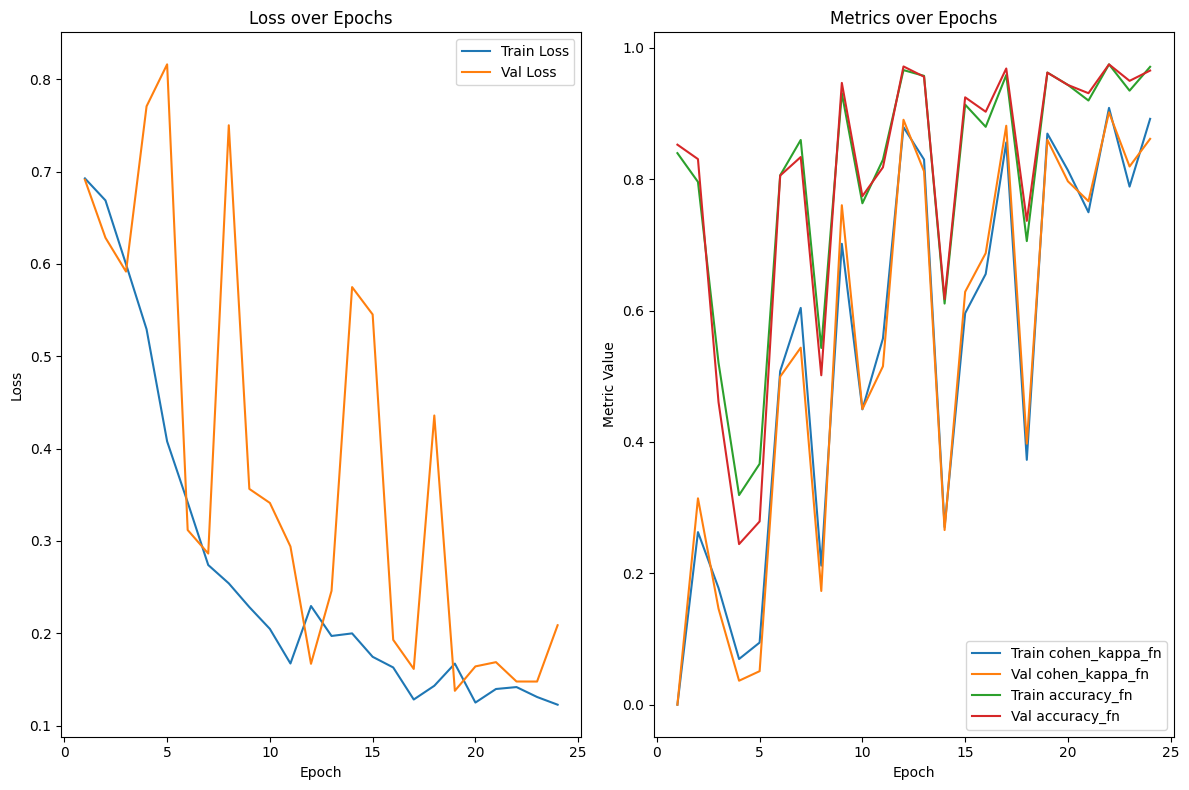

In [65]:
trainer_cnn_7.plot_epochs()

In [66]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1848 | Test cohen_kappa_fn: 0.7882 | Test accuracy_fn: 0.9417


#### Visualization

In [67]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

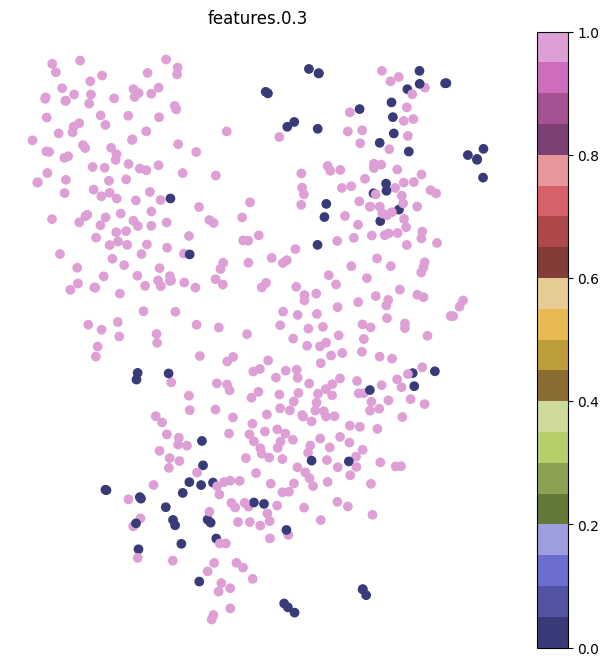

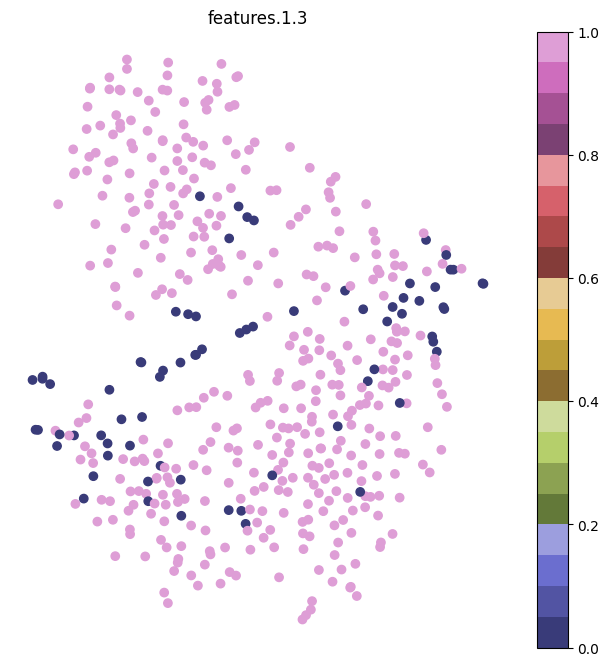

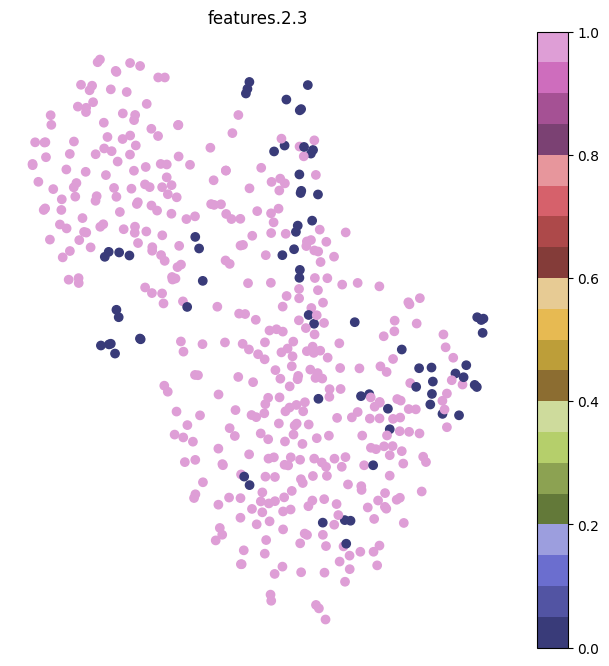

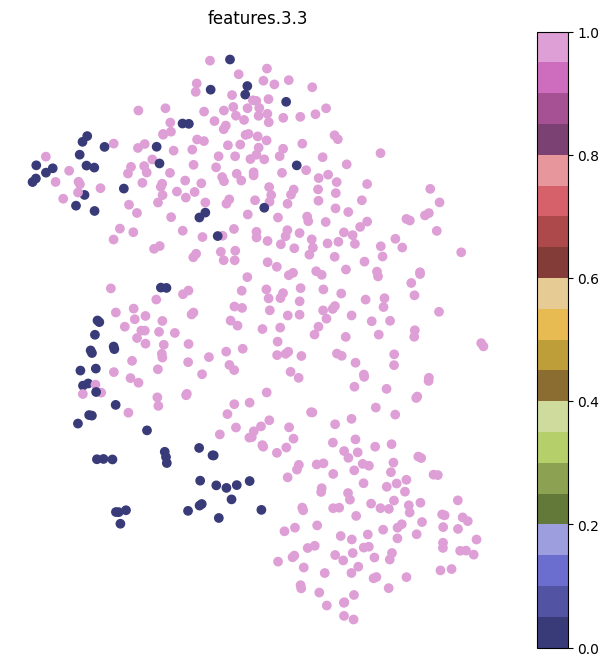

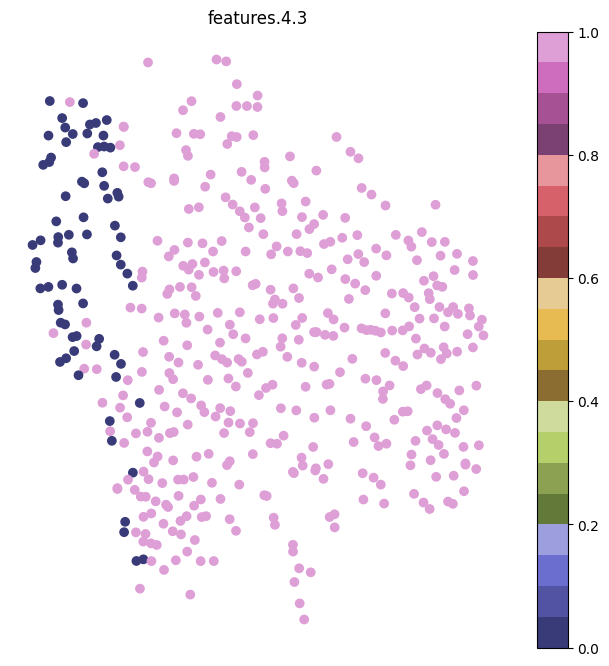

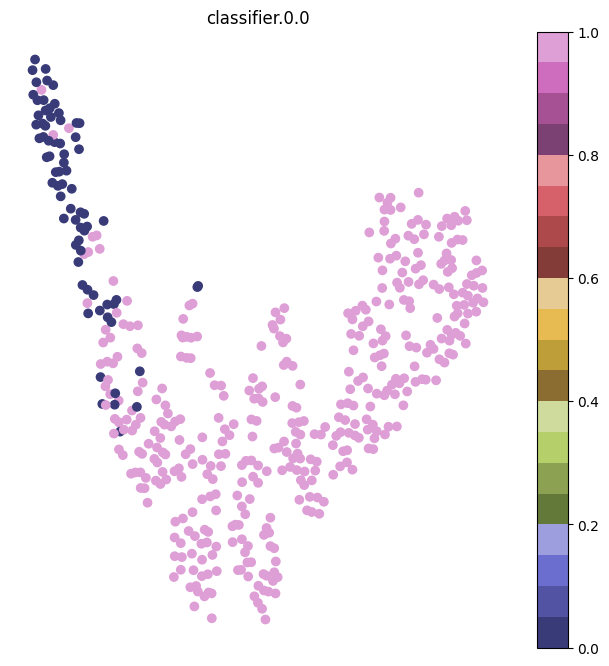

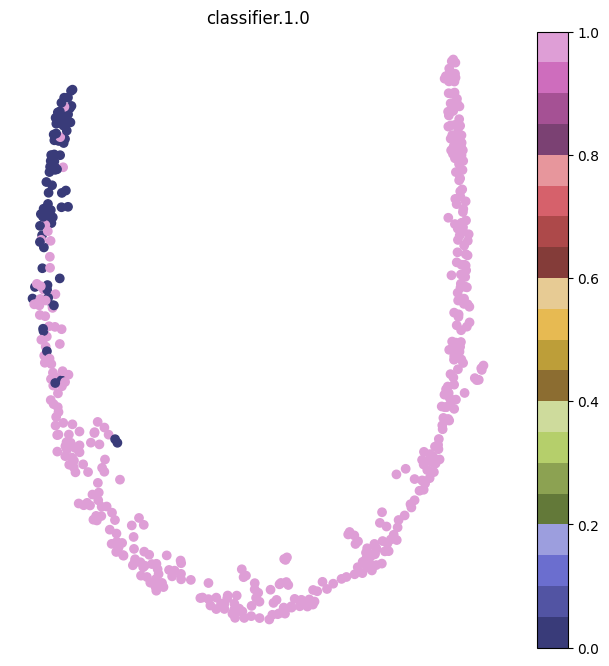

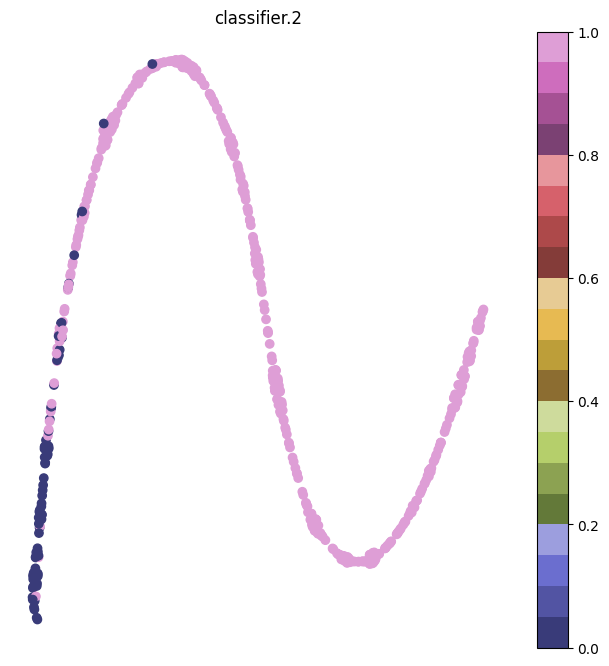

In [68]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


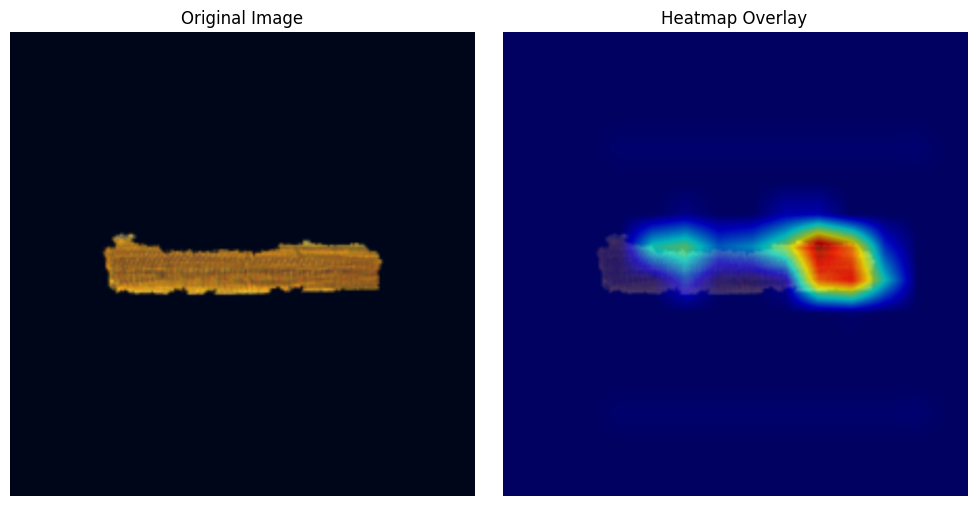

  Generating heatmap for Larvae...
  Predicted label is Larvae!


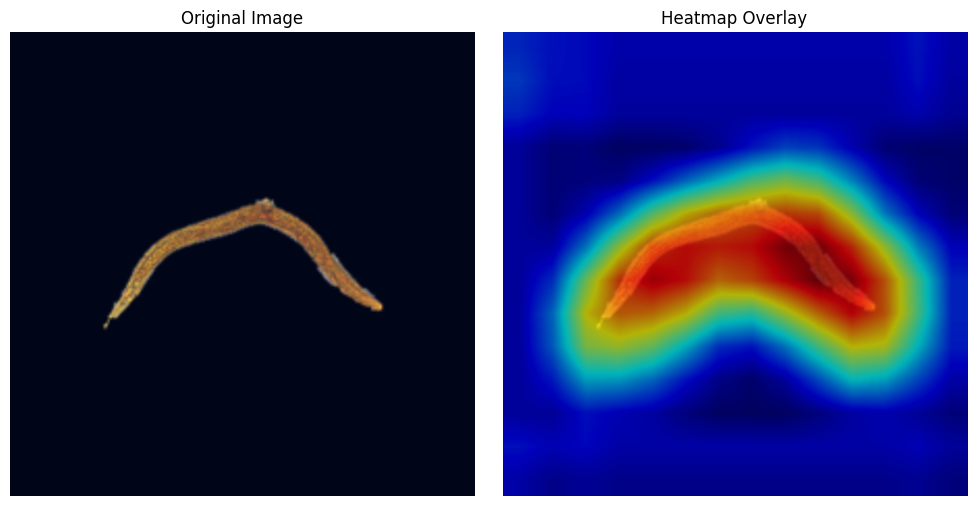

In [69]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break